# Compare the CIGALE results of EMU and non-EMU sources

In [1]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import math


# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
# Use the Planck 2020/2018 cosmology
from astropy.cosmology import Planck18 as cosmo

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import gaussian_kde

from string import ascii_letters

# Seaborn
import seaborn as sns

# Custom color palette
set2_colors = sns.color_palette('Paired')
custom_palette = [set2_colors[1], set2_colors[5]]

sns.color_palette(custom_palette)


[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

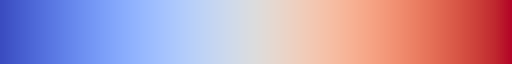

In [3]:
sns.color_palette("coolwarm", as_cmap=True)

## Import results files from EMU and non-EMU sources and select objects with x²_red < 5

In [4]:
emu_sources = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/emu_data/out_withAGN_1/results.txt', sep='\s+')
nonemu_sources = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/nonemu_sample_1/results.txt', sep='\s+')
nonemu_prototypes = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/nonemu_prototypes/results.txt', sep='\s+')
nonemu_samp_prots = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/out/results.txt', sep='\s+')

Select EMU and non-EMU sources with a x²_red less than 5 , to analyse sources with a good fitting.

In [5]:
# EMU sources
best_matches_emu = emu_sources['best.reduced_chi_square'] <= 5.0
emu_sources_best = emu_sources[best_matches_emu].copy()
print(f'Number of emu objects with x²_red <= 5: {len(emu_sources_best)}/{len(emu_sources)}')
emu_sources_best['bayes.sfh.sfr_permass'] =  emu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star']
emu_sources_best['best.sfh.sfr_permass'] =  emu_sources_best['best.sfh.sfr']/emu_sources_best['best.stellar.m_star']

# Non-EMU with same g-mag distribution as EMU
best_matches_nonemu = nonemu_sources['best.reduced_chi_square'] <= 5.0 
nonemu_sources_best = nonemu_sources[best_matches_nonemu].copy()
print(f'Number of non-emu objects with x²_red <= 5: {len(nonemu_sources_best)}/{len(nonemu_sources)}')
nonemu_sources_best['bayes.sfh.sfr_permass'] =  nonemu_sources_best['bayes.sfh.sfr']/nonemu_sources_best['bayes.stellar.m_star']

# Prototypes
best_matches_nonemu_prots = nonemu_prototypes['best.reduced_chi_square'] <= 5.0
nonemu_prototypes_best = nonemu_prototypes[best_matches_nonemu_prots].copy()
print(f'Number of non-emu prototypes with x²_red <= 5: {len(nonemu_prototypes_best)}/{len(nonemu_prototypes)}')
nonemu_prototypes_best['bayes.sfh.sfr_permass'] =  nonemu_prototypes_best['bayes.sfh.sfr']/nonemu_prototypes_best['bayes.stellar.m_star']

# Non-EMU sample with original distribution (BMUs of the prototypes)
best_matches_nonemu_samp_prots = nonemu_samp_prots['best.reduced_chi_square'] <= 5.0
nonemu_samp_prots_best = nonemu_samp_prots[best_matches_nonemu_samp_prots].copy()
print(f'Number of non-emu prototypes with x²_red <= 5: {len(nonemu_samp_prots_best)}/{len(nonemu_samp_prots_best)}')
nonemu_samp_prots_best['bayes.sfh.sfr_permass'] =  nonemu_samp_prots_best['bayes.sfh.sfr']/nonemu_samp_prots_best['bayes.stellar.m_star']
nonemu_samp_prots_best['best.sfh.sfr_permass'] =  nonemu_samp_prots_best['best.sfh.sfr']/nonemu_samp_prots_best['best.stellar.m_star']

Number of emu objects with x²_red <= 5: 3506/3530
Number of non-emu objects with x²_red <= 5: 3053/3530
Number of non-emu prototypes with x²_red <= 5: 2693/2756
Number of non-emu prototypes with x²_red <= 5: 4843/4843


In [6]:
# Add filtering to ensure we keep the values whose errors are not too high
def filter_by_error(df, column):
    return df[(df[column+'_err'] < df[column])]

emu_sources_best = filter_by_error(emu_sources_best, 'bayes.sfh.sfr')
emu_sources_best = filter_by_error(emu_sources_best, 'bayes.stellar.m_star')
nonemu_sources_best = filter_by_error(nonemu_sources_best, 'bayes.sfh.sfr')
nonemu_sources_best = filter_by_error(nonemu_sources_best, 'bayes.stellar.m_star')

## Average Values

In [7]:
def simple_avg_and_error(values, errors):
    values = np.asarray(values)
    
    avg = np.mean(values)
    avg_error = np.std(errors)
    
    return avg, avg_error

In [8]:
print("EMU values")

emu_avg_stellarmass, emu_err_stellarmass = simple_avg_and_error(emu_sources_best['bayes.stellar.m_star'], emu_sources_best['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(emu_avg_stellarmass):.4f} ± {np.log10(emu_err_stellarmass):.4f}')

emu_avg_sfr, emu_err_sfr = simple_avg_and_error(emu_sources_best['bayes.sfh.sfr'], emu_sources_best['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(emu_avg_sfr):.4f} ± {np.log10(emu_err_sfr):.4f}')

emu_avg_ssfr, emu_err_ssfr = simple_avg_and_error(emu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star'], emu_sources_best['bayes.sfh.sfr_err']/emu_sources_best['bayes.stellar.m_star_err'])
print(r'Specific Star Formation Rate:', f'{np.log10(emu_avg_ssfr):.4f} ± {np.log10(emu_err_ssfr):.4f}')

emu_avg_metallicity, emu_err_metallicity = simple_avg_and_error(emu_sources_best['bayes.stellar.metallicity'], emu_sources_best['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{emu_avg_metallicity:.4f} ± {emu_err_metallicity:.4f}')

emu_avg_age, emu_err_age = simple_avg_and_error(emu_sources_best['bayes.sfh.age'], emu_sources_best['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(emu_avg_age):.4f} ± {np.log10(emu_err_age):.4f}')

emu_avg_Av_BC, emu_err_Av_BC = simple_avg_and_error(emu_sources_best['bayes.attenuation.Av_BC'], emu_sources_best['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{emu_avg_Av_BC:.4f} ± {emu_err_Av_BC:.4f}')

emu_avg_AGN, emu_err_AGN = simple_avg_and_error(emu_sources_best['bayes.agn.fracAGN'], emu_sources_best['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{emu_avg_AGN:.4f} ± {emu_err_AGN:.4f}')

emu_avg_red, emu_err_red = simple_avg_and_error(emu_sources_best['bayes.universe.redshift'], emu_sources_best['bayes.universe.redshift_err'])
print(r'Redshift:', f'{emu_avg_red:.4f} ± {emu_err_red:.4f}')

EMU values
Stellar Mass: 11.3105 ± 11.4614
Star Formation Rate: 2.9068 ± 3.6189
Specific Star Formation Rate: -8.7990 ± -8.2476
Metallicity: 0.0221 ± 0.0040
Age: 3.5225 ± 2.8031
Av_BC: 0.5241 ± 0.0766
AGN Fraction: 0.1514 ± 0.0773
Redshift: 0.8259 ± 0.2568


In [9]:
print("NON EMU - Sample with the same distribution in the g magnitude as EMU")

nonemu_avg_stellarmass, nonemu_err_stellarmass = simple_avg_and_error(nonemu_sources_best['bayes.stellar.m_star'], nonemu_sources_best['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(nonemu_avg_stellarmass):.4f} ± {np.log10(nonemu_err_stellarmass):.4f}')

nonemu_avg_sfr, nonemu_err_sfr = simple_avg_and_error(nonemu_sources_best['bayes.sfh.sfr'], nonemu_sources_best['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(nonemu_avg_sfr):.4f} ± {np.log10(nonemu_err_sfr):.4f}')

nonemu_avg_ssfr, nonemu_err_ssfr = simple_avg_and_error(nonemu_sources_best['bayes.sfh.sfr']/nonemu_sources_best['bayes.stellar.m_star'], nonemu_sources_best['bayes.sfh.sfr_err']/nonemu_sources_best['bayes.stellar.m_star_err'])
print(r'Specific Star Formation Rate:', f'{np.log10(nonemu_avg_ssfr):.4f} ± {np.log10(nonemu_err_ssfr):.4f}')

nonemu_avg_metallicity, nonemu_err_metallicity = simple_avg_and_error(nonemu_sources_best['bayes.stellar.metallicity'], nonemu_sources_best['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{nonemu_avg_metallicity:.4f} ± {nonemu_err_metallicity:.4f}')

nonemu_avg_age, nonemu_err_age = simple_avg_and_error(nonemu_sources_best['bayes.sfh.age'], nonemu_sources_best['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(nonemu_avg_age):.4f} ± {np.log10(nonemu_err_age):.4f}')

nonemu_avg_Av_BC, nonemu_err_Av_BC = simple_avg_and_error(nonemu_sources_best['bayes.attenuation.Av_BC'], nonemu_sources_best['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{nonemu_avg_Av_BC:.4f} ± {nonemu_err_Av_BC:.4f}')

avg_AGN, err_AGN = simple_avg_and_error(nonemu_sources_best['bayes.agn.fracAGN'], nonemu_sources_best['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{avg_AGN:.4f} ± {err_AGN:.4f}')

avg_red, err_red = simple_avg_and_error(nonemu_sources_best['bayes.universe.redshift'], nonemu_sources_best['bayes.universe.redshift_err'])
print(r'Redshift:', f'{avg_red:.4f} ± {err_red:.4f}')

NON EMU - Sample with the same distribution in the g magnitude as EMU
Stellar Mass: 10.9100 ± 10.8789
Star Formation Rate: 2.1492 ± 2.7028
Specific Star Formation Rate: -9.0394 ± -8.3989
Metallicity: 0.0180 ± 0.0046
Age: 3.6280 ± 2.8119
Av_BC: 0.3087 ± 0.0856
AGN Fraction: 0.1238 ± 0.0681
Redshift: 0.6084 ± 0.2260


In [10]:
print("NON EMU - Sample with the same distribution as the original set of non-EMU sources")

nonemu_samp_prots_stellarmass, nonemu_samp_prots_err_stellarmass = simple_avg_and_error(nonemu_samp_prots_best['bayes.stellar.m_star'], nonemu_samp_prots_best['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(nonemu_samp_prots_stellarmass):.4f} ± {np.log10(nonemu_samp_prots_err_stellarmass):.4f}')

nonemu_samp_prots_sfr, nonemu_samp_prots_err_sfr = simple_avg_and_error(nonemu_samp_prots_best['bayes.sfh.sfr'], nonemu_samp_prots_best['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(nonemu_samp_prots_sfr):.4f} ± {np.log10(nonemu_samp_prots_err_sfr):.4f}')

nonemu_samp_prots_ssfr, nonemu_samp_prots_err_ssfr = simple_avg_and_error(nonemu_samp_prots_best['bayes.sfh.sfr']/nonemu_samp_prots_best['bayes.stellar.m_star'], nonemu_samp_prots_best['bayes.sfh.sfr_err']/nonemu_samp_prots_best['bayes.stellar.m_star_err'])
print(r'Specific Star Formation Rate:', f'{np.log10(nonemu_samp_prots_ssfr):.4f} ± {np.log10(nonemu_samp_prots_err_ssfr):.4f}')

nonemu_samp_prots_metallicity, nonemu_samp_prots_err_metallicity = simple_avg_and_error(nonemu_samp_prots_best['bayes.stellar.metallicity'], nonemu_samp_prots_best['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{nonemu_samp_prots_metallicity:.4f} ± {nonemu_samp_prots_err_metallicity:.4f}')

nonemu_samp_prots_age, nonemu_samp_prots_err_age = simple_avg_and_error(nonemu_samp_prots_best['bayes.sfh.age'], nonemu_samp_prots_best['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(nonemu_samp_prots_age):.4f} ± {np.log10(nonemu_samp_prots_err_age):.4f}')

nonemu_samp_prots_Av_BC, nonemu_samp_prots_err_Av_BC = simple_avg_and_error(nonemu_samp_prots_best['bayes.attenuation.Av_BC'], nonemu_samp_prots_best['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{nonemu_samp_prots_Av_BC:.4f} ± {nonemu_samp_prots_err_Av_BC:.4f}')

nonemu_samp_prots_AGN, nonemu_samp_prots_err_AGN = simple_avg_and_error(nonemu_samp_prots_best['bayes.agn.fracAGN'], nonemu_samp_prots_best['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{nonemu_samp_prots_AGN:.4f} ± {nonemu_samp_prots_err_AGN:.4f}')

nonemu_samp_prots_red, nonemu_samp_prots_err_red = simple_avg_and_error(nonemu_samp_prots_best['bayes.universe.redshift'], nonemu_samp_prots_best['bayes.universe.redshift_err'])
print(r'Redshift:', f'{nonemu_samp_prots_red:.4f} ± {nonemu_samp_prots_err_red:.4f}')

NON EMU - Sample with the same distribution as the original set of non-EMU sources
Stellar Mass: 10.7290 ± 10.5453
Star Formation Rate: 1.8625 ± 2.7493
Specific Star Formation Rate: -8.7851 ± -8.0210
Metallicity: 0.0201 ± 0.0048
Age: 3.5871 ± 2.8189
Av_BC: 0.3847 ± 0.1016
AGN Fraction: 0.1650 ± 0.0666
Redshift: 0.5818 ± 0.2156


In [11]:
print("NON EMU - Prototypes")

nonemu_prots_stellarmass, nonemu_prots_err_stellarmass = simple_avg_and_error(nonemu_prototypes_best['bayes.stellar.m_star'], nonemu_prototypes_best['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(nonemu_prots_stellarmass):.4f} ± {np.log10(nonemu_prots_err_stellarmass):.4f}')

nonemu_prots_sfr, nonemu_prots_err_sfr = simple_avg_and_error(nonemu_prototypes_best['bayes.sfh.sfr'], nonemu_prototypes_best['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(nonemu_prots_sfr):.4f} ± {np.log10(nonemu_prots_err_sfr):.4f}')

nonemu_prots_ssfr, nonemu_prots_err_ssfr = simple_avg_and_error(nonemu_prototypes_best['bayes.sfh.sfr']/nonemu_prototypes_best['bayes.stellar.m_star'], nonemu_prototypes_best['bayes.sfh.sfr_err']/nonemu_prototypes_best['bayes.stellar.m_star_err'])
print(r'Specific Star Formation Rate:', f'{np.log10(nonemu_prots_ssfr):.4f} ± {np.log10(nonemu_prots_err_ssfr):.4f}')

nonemu_prots_metallicity, nonemu_prots_err_metallicity = simple_avg_and_error(nonemu_prototypes_best['bayes.stellar.metallicity'], nonemu_prototypes_best['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{nonemu_prots_metallicity:.4f} ± {nonemu_prots_err_metallicity:.4f}')

nonemu_prots_age, nonemu_prots_err_age = simple_avg_and_error(nonemu_prototypes_best['bayes.sfh.age'], nonemu_prototypes_best['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(nonemu_prots_age):.4f} ± {np.log10(nonemu_prots_err_age):.4f}')

nonemu_prots_Av_BC, nonemu_prots_err_Av_BC = simple_avg_and_error(nonemu_prototypes_best['bayes.attenuation.Av_BC'], nonemu_prototypes_best['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{nonemu_prots_Av_BC:.4f} ± {nonemu_prots_err_Av_BC:.4f}')

nonemu_prots_AGN, nonemu_prots_err_AGN = simple_avg_and_error(nonemu_prototypes_best['bayes.agn.fracAGN'], nonemu_prototypes_best['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{nonemu_prots_AGN:.4f} ± {nonemu_prots_err_AGN:.4f}')

nonemu_prots_red, nonemu_prots_err_red = simple_avg_and_error(nonemu_prototypes_best['bayes.universe.redshift'], nonemu_prototypes_best['bayes.universe.redshift_err'])
print(r'Redshift:', f'{nonemu_prots_red:.4f} ± {nonemu_prots_err_red:.4f}')

NON EMU - Prototypes
Stellar Mass: 10.6716 ± 10.4660
Star Formation Rate: 1.9763 ± 2.6302
Specific Star Formation Rate: -8.7493 ± -8.0187
Metallicity: 0.0202 ± 0.0034
Age: 3.6178 ± 2.7295
Av_BC: 0.4248 ± 0.0880
AGN Fraction: 0.1665 ± 0.0536
Redshift: 0.5788 ± 0.2132


## Logarithmic values

In [12]:
# EMU
emu_sources_best['log_stellar_mass'] = np.log10(emu_sources_best['bayes.stellar.m_star'])
emu_sources_best['log_sfr'] = np.log10(emu_sources_best['bayes.sfh.sfr'])
emu_sources_best['log_ssfr'] = np.log10(emu_sources_best['bayes.sfh.sfr'] / emu_sources_best['bayes.stellar.m_star'])
emu_sources_best['log_metallicity'] = np.log10(emu_sources_best['bayes.stellar.metallicity'])
emu_sources_best['log_age'] = np.log10(emu_sources_best['bayes.sfh.age'])
emu_sources_best['log_attenuation'] = np.log10(emu_sources_best['bayes.attenuation.Av_BC'])

In [13]:
# NON EMU - Sample with the same distribution in the g magnitude as EMU
nonemu_sources_best['log_stellar_mass'] = np.log10(nonemu_sources_best['bayes.stellar.m_star'])
nonemu_sources_best['log_sfr'] = np.log10(nonemu_sources_best['bayes.sfh.sfr'])
nonemu_sources_best['log_ssfr'] = np.log10(nonemu_sources_best['bayes.sfh.sfr'] / nonemu_sources_best['bayes.stellar.m_star'])
nonemu_sources_best['log_metallicity'] = np.log10(nonemu_sources_best['bayes.stellar.metallicity'])
nonemu_sources_best['log_age'] = np.log10(nonemu_sources_best['bayes.sfh.age'])
nonemu_sources_best['log_attenuation'] = np.log10(nonemu_sources_best['bayes.attenuation.Av_BC'])

In [14]:
# NON EMU - Sample with the same distribution as the original set of non-EMU sources
nonemu_samp_prots_best['log_stellar_mass'] = np.log10(nonemu_samp_prots_best['bayes.stellar.m_star'])
nonemu_samp_prots_best['log_sfr'] = np.log10(nonemu_samp_prots_best['bayes.sfh.sfr'])
nonemu_samp_prots_best['log_ssfr'] = np.log10(nonemu_samp_prots_best['bayes.sfh.sfr'] / nonemu_samp_prots_best['bayes.stellar.m_star'])
nonemu_samp_prots_best['log_metallicity'] = np.log10(nonemu_samp_prots_best['bayes.stellar.metallicity'])
nonemu_samp_prots_best['log_age'] = np.log10(nonemu_samp_prots_best['bayes.sfh.age'])
nonemu_samp_prots_best['log_attenuation'] = np.log10(nonemu_samp_prots_best['bayes.attenuation.Av_BC'])

In [15]:
# NON EMU - Prototypes
nonemu_prototypes_best['log_stellar_mass'] = np.log10(nonemu_prototypes_best['bayes.stellar.m_star'])
nonemu_prototypes_best['log_sfr'] = np.log10(nonemu_prototypes_best['bayes.sfh.sfr'])
nonemu_prototypes_best['log_ssfr'] = np.log10(nonemu_prototypes_best['bayes.sfh.sfr'] / nonemu_prototypes_best['bayes.stellar.m_star'])
nonemu_prototypes_best['log_metallicity'] = np.log10(nonemu_prototypes_best['bayes.stellar.metallicity'])
nonemu_prototypes_best['log_age'] = np.log10(nonemu_prototypes_best['bayes.sfh.age'])
nonemu_prototypes_best['log_attenuation'] = np.log10(nonemu_prototypes_best['bayes.attenuation.Av_BC'])

## Compare EMU and non-EMU sources

### Diagonal Correlation Matrix

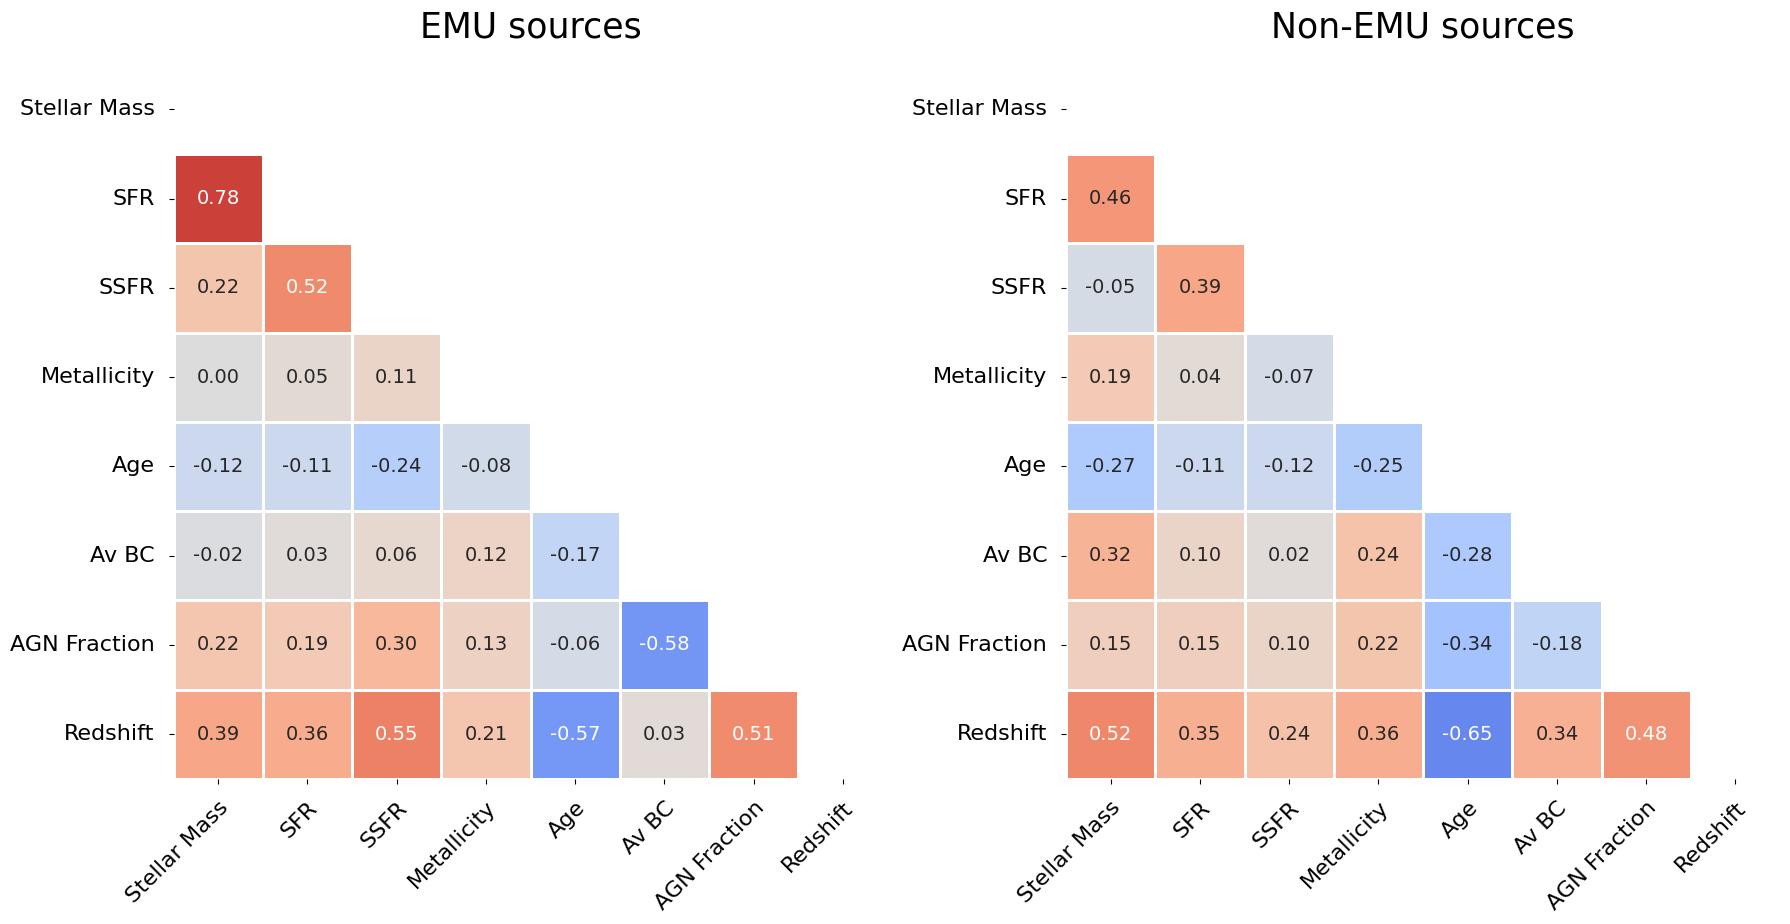

In [16]:
# Prepare the data
emu_sources_best_cols = emu_sources_best[['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass', 
                                         'bayes.stellar.metallicity', 'bayes.sfh.age', 
                                         'bayes.attenuation.Av_BC', 'bayes.agn.fracAGN', 
                                         'bayes.universe.redshift']]
nonemu_samp_prots_best_cols = nonemu_samp_prots_best[['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass',
                                              'bayes.stellar.metallicity', 'bayes.sfh.age',
                                              'bayes.attenuation.Av_BC', 'bayes.agn.fracAGN',
                                              'bayes.universe.redshift']]

new_column_labels = {
    'bayes.stellar.m_star': 'Stellar Mass',
    'bayes.sfh.sfr': 'SFR',
    'bayes.sfh.sfr_permass': 'SSFR',
    'bayes.stellar.metallicity': 'Metallicity',
    'bayes.sfh.age': 'Age',
    'bayes.attenuation.Av_BC': 'Av BC',
    'bayes.agn.fracAGN': 'AGN Fraction',
    'bayes.universe.redshift': 'Redshift'
}

# Compute correlation matrices
emu_sources_best_cor = emu_sources_best_cols.corr()
nonemu_samp_prots_best_cor = nonemu_samp_prots_best_cols.corr()

# Rename columns and index
emu_sources_best_cor = emu_sources_best_cor.rename(index=new_column_labels, columns=new_column_labels)
nonemu_samp_prots_best_cor = nonemu_samp_prots_best_cor.rename(index=new_column_labels, columns=new_column_labels)

# Create mask for upper triangle
mask = np.triu(np.ones_like(emu_sources_best_cor, dtype=bool))

# Set up the figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1]})
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Custom font sizes
title_fontsize = 25
label_fontsize = 18
tick_fontsize = 16
annot_fontsize = 14

# First heatmap (EMU)
sns.heatmap(emu_sources_best_cor, mask=mask, cmap=cmap, vmin=-0.9, vmax=0.9, center=0,
            square=True, linewidths=.75, ax=ax1,
            cbar=False,  
            annot=True, fmt=".2f",
            annot_kws={"size": annot_fontsize})
ax1.set_title('EMU sources', fontsize=title_fontsize, pad=20)

# Second heatmap (Non-EMU)
sns.heatmap(nonemu_samp_prots_best_cor, mask=mask, cmap=cmap, vmin=-0.9, vmax=0.9, center=0,
            square=True, linewidths=.75, ax=ax2,
            cbar=False, 
            annot=True, fmt=".2f",
            annot_kws={"size": annot_fontsize})
ax2.set_title('Non-EMU sources', fontsize=title_fontsize, pad=20)

# Adjust tick labels for both subplots
for ax in [ax1, ax2]:
    # X-axis labels (bottom)
    ax.set_xticklabels(ax.get_xticklabels(), 
                      rotation=45, 
                      ha='right',  # Align to the right
                      rotation_mode='anchor',  # Rotate around anchor point
                      fontsize=tick_fontsize)
    
    # Y-axis labels (left)
    ax.set_yticklabels(ax.get_yticklabels(), 
                       rotation=0, 
                       ha='right',  # Align to the right
                       fontsize=tick_fontsize)
    
    # Adjust layout to prevent label cutoff
    ax.tick_params(axis='both', which='both', pad=10)

# Add a shared colorbar
# cbar_ax = f.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
# f.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for colorbar
plt.show()

### All Properties Plot

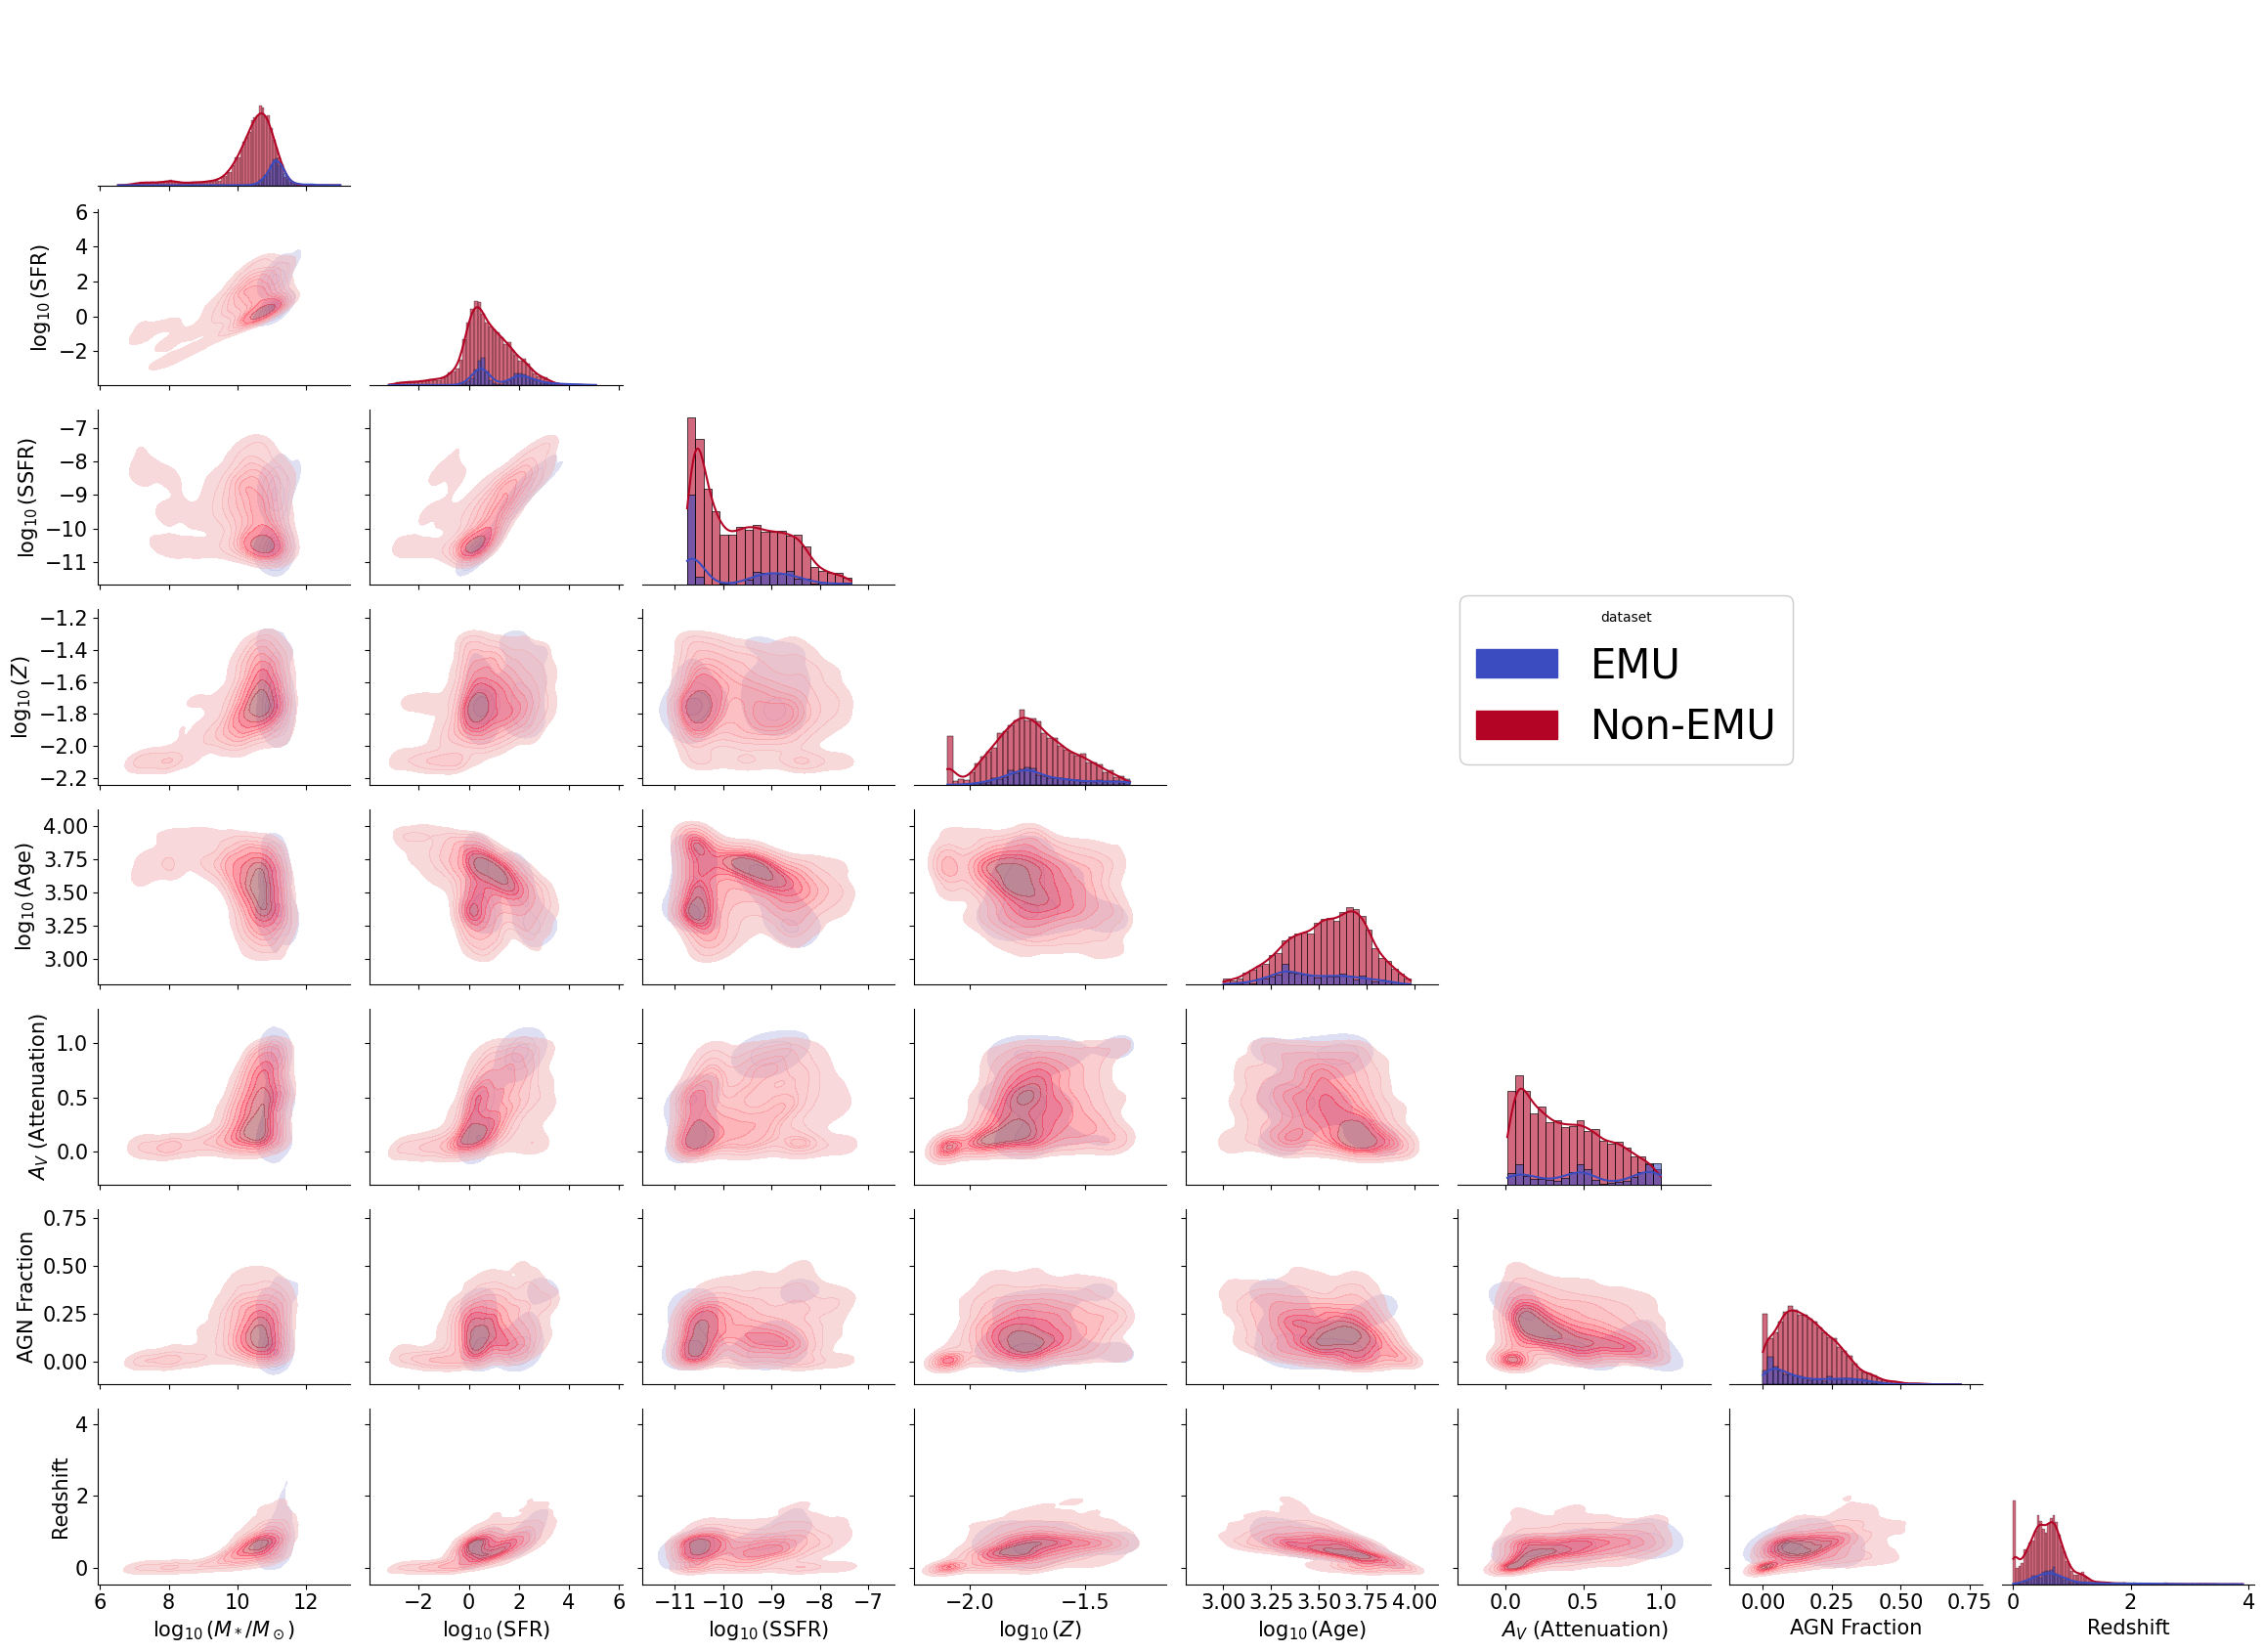

In [17]:
custom_palette = {
    'EMU': cmap(0.0)[:3],
    'Non-EMU': cmap(1.0)[:3]
}

# Define properties
properties = [
    'log_stellar_mass', 'log_sfr', 'log_ssfr',
    'log_metallicity', 'log_age', 'bayes.attenuation.Av_BC',
    'bayes.agn.fracAGN', 'bayes.universe.redshift'
]

emu_sources_best['dataset'] = 'EMU'
nonemu_samp_prots_best['dataset'] = 'Non-EMU'
joined_df = pd.concat([emu_sources_best, nonemu_samp_prots_best], ignore_index=True)

labels = [
    r'$\log_{10}(M_*/M_\odot)$', 
    r'$\log_{10}(\mathrm{SFR})$', 
    r'$\log_{10}(\mathrm{SSFR})$', 
    r'$\log_{10}(Z)$', 
    r'$\log_{10}(\mathrm{Age})$',
    r'$A_V$ (Attenuation)', 
    r'AGN Fraction', 
    r'Redshift'
]

# --- Font Customization ---
xlabel_fontsize = 15     # X-axis labels (e.g., "log10(M*/Mo)")
ylabel_fontsize = 15     # Y-axis labels 
xtick_fontsize = 15      # X-axis tick numbers
ytick_fontsize = 15      # Y-axis tick numbers
legend_fontsize = 30     # Legend text

# --- Create PairGrid ---
g = sns.PairGrid(
    joined_df, 
    vars=properties, 
    hue='dataset', 
    corner=True, 
    palette=custom_palette
)

# Lower triangle: KDE plots
g.map_lower(
    sns.kdeplot, 
    fill=True, 
    alpha=0.5, 
    thresh=0.05
)

# Diagonal: Histograms
g.map_diag(
    sns.histplot, 
    kde=True, 
    alpha=0.6
)

# --- Axis Label & Tick Customization ---
# X-axis labels (bottom row)
for ax, label in zip(g.axes[-1, :], labels):
    ax.set_xlabel(label, fontsize=xlabel_fontsize)
    ax.tick_params(axis='x', labelsize=xtick_fontsize)

# Y-axis labels (first column)
for ax, label in zip(g.axes[:, 0], labels):
    ax.set_ylabel(label, fontsize=ylabel_fontsize)
    ax.tick_params(axis='y', labelsize=ytick_fontsize)

# --- Legend Customization ---
g.add_legend(
    bbox_to_anchor=(0.8, 0.5),  # Adjust position as needed
    fontsize=legend_fontsize,
    frameon=True,
    framealpha=1
)

plt.tight_layout(rect=[0, 0, 1, 0.85])  # Prevent legend overlap
plt.show()


### Histogram of EMU and non-EMU sources

In [18]:
def plot_log_hist_percent_2rows_sns(
    df1, df2, columns, x_labels, legend_positions,
    labels, titles, values1, values2, errors1, errors2, 
    figsize=(25, 10), bins=50,
    title_fontsize=20,           # Subplot title size
    xlabel_fontsize=20,          # X-axis label size
    ylabel_fontsize=20,          # Y-axis label size
    xtick_fontsize=20,           # X-axis tick size
    ytick_fontsize=20,           # Y-axis tick size
    legend_fontsize=10,          # Legend text size
    color1='#0000ff',
    color2='#fb0404'
):

    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    # Pre-calculate bins based on df1 but extended to cover df2 if needed
    extended_bins = {}
    for col in columns:
        if ('bayes.agn.fracAGN' in col) or ('bayes.stellar.metallicity' in col) or \
           ('bayes.universe.greenshift' in col) or ('bayes.attenuation.Av_BC' in col):
            # Linear scale bins
            min_val = df1[col].min()
            max_val = df1[col].max()
            # Extend if df2 has values outside
            min_val = min(min_val, df2[col].min())
            max_val = max(max_val, df2[col].max())
            extended_bins[col] = np.linspace(min_val, max_val, bins)
        else:
            # Log scale bins (only positive values)
            data1 = df1[col][df1[col] > 0]
            data2 = df2[col][df2[col] > 0]
            
            if not data1.empty:
                min_val = data1.min()
                max_val = data1.max()
                # Extend if df2 has values outside
                if not data2.empty:
                    min_val = min(min_val, data2.min())
                    max_val = max(max_val, data2.max())
                extended_bins[col] = np.logspace(np.log10(min_val), np.log10(max_val), bins)
            else:
                # Fallback: Use df2 if df1 has no valid data
                if not data2.empty:
                    min_val = data2.min()
                    max_val = data2.max()
                    extended_bins[col] = np.logspace(np.log10(min_val), np.log10(max_val), bins)
                else:
                    # Fallback if both are empty (shouldn't happen, but just in case)
                    extended_bins[col] = np.logspace(0, 1, bins)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]

        data1 = df1[col]
        data2 = df2[col]

        if ('bayes.agn.fracAGN' in col) or ('bayes.stellar.metallicity' in col) or \
           ('bayes.universe.redshift' in col) or ('bayes.attenuation.Av_BC' in col):
            # Linear scale
            ax.hist(
                data1,
                bins=extended_bins[col],
                weights=np.ones_like(data1) * 100 / len(data1),
                alpha=0.5,
                label=labels[0],
                color=color1
            )
            ax.hist(
                data2,
                bins=extended_bins[col],
                weights=np.ones_like(data2) * 100 / len(data2),
                alpha=0.5,
                label=labels[1],
                color=color2
            )
            # Medians
            ax.axvline(data1.median(), color=color1, linestyle='dashed', linewidth=1.5, 
                       label=f'{values1[i]:.3f} ± {errors1[i]:.3f}')
            ax.axvline(data2.median(), color=color2, linestyle='dashed', linewidth=1.5, 
                       label=f'{values2[i]:.3f} ± {errors2[i]:.3f}')

            ax.set_xlabel(x_labels[i], fontsize=xlabel_fontsize)  # X-axis label size
            ax.set_ylabel('Percentage of Sources [%]', fontsize=ylabel_fontsize)  # Y-axis label size
            ax.tick_params(axis='x', labelsize=xtick_fontsize)  # X-axis ticks
            ax.tick_params(axis='y', labelsize=ytick_fontsize)  # Y-axis ticks

        else:
            # Log scale
            data1 = data1[data1 > 0]
            data2 = data2[data2 > 0]

            ax.hist(
                data1,
                bins=extended_bins[col],
                weights=np.ones_like(data1) * 100 / len(data1),
                alpha=0.5,
                label=labels[0],
                color=color1
            )
            ax.hist(
                data2,
                bins=extended_bins[col],
                weights=np.ones_like(data2) * 100 / len(data2),
                alpha=0.5,
                label=labels[1],
                color=color2
            )
            ax.set_xscale('log')
            ax.set_xlabel(x_labels[i], fontsize=xlabel_fontsize)  # X-axis label size
            ax.set_ylabel('Percentage of Sources [%]', fontsize=ylabel_fontsize)  # Y-axis label size
            ax.tick_params(axis='x', labelsize=xtick_fontsize)  # X-axis ticks (log scale)
            ax.tick_params(axis='y', labelsize=ytick_fontsize)  # Y-axis ticks

            # Medians (log scale plots)
            ax.axvline(data1.median(), color=color1, linestyle='dashed', linewidth=1.5, 
                       label=f'10^({values1[i]:.3f} ± {errors1[i]:.3f})')
            ax.axvline(data2.median(), color=color2, linestyle='dashed', linewidth=1.5, 
                       label=f'10^({values2[i]:.3f} ± {errors2[i]:.3f})')

        ax.set_title(titles[i], fontsize=title_fontsize)  # Title size
        ax.legend(loc=legend_positions[i], fontsize=legend_fontsize)  # Legend text size

    # Hide unused subplots
    for j in range(n, nrows * ncols):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.savefig("/home/polaris/Lab_Astro/cigale.png", dpi=72)
    plt.show()

#### EMU sources vs Non-EMU

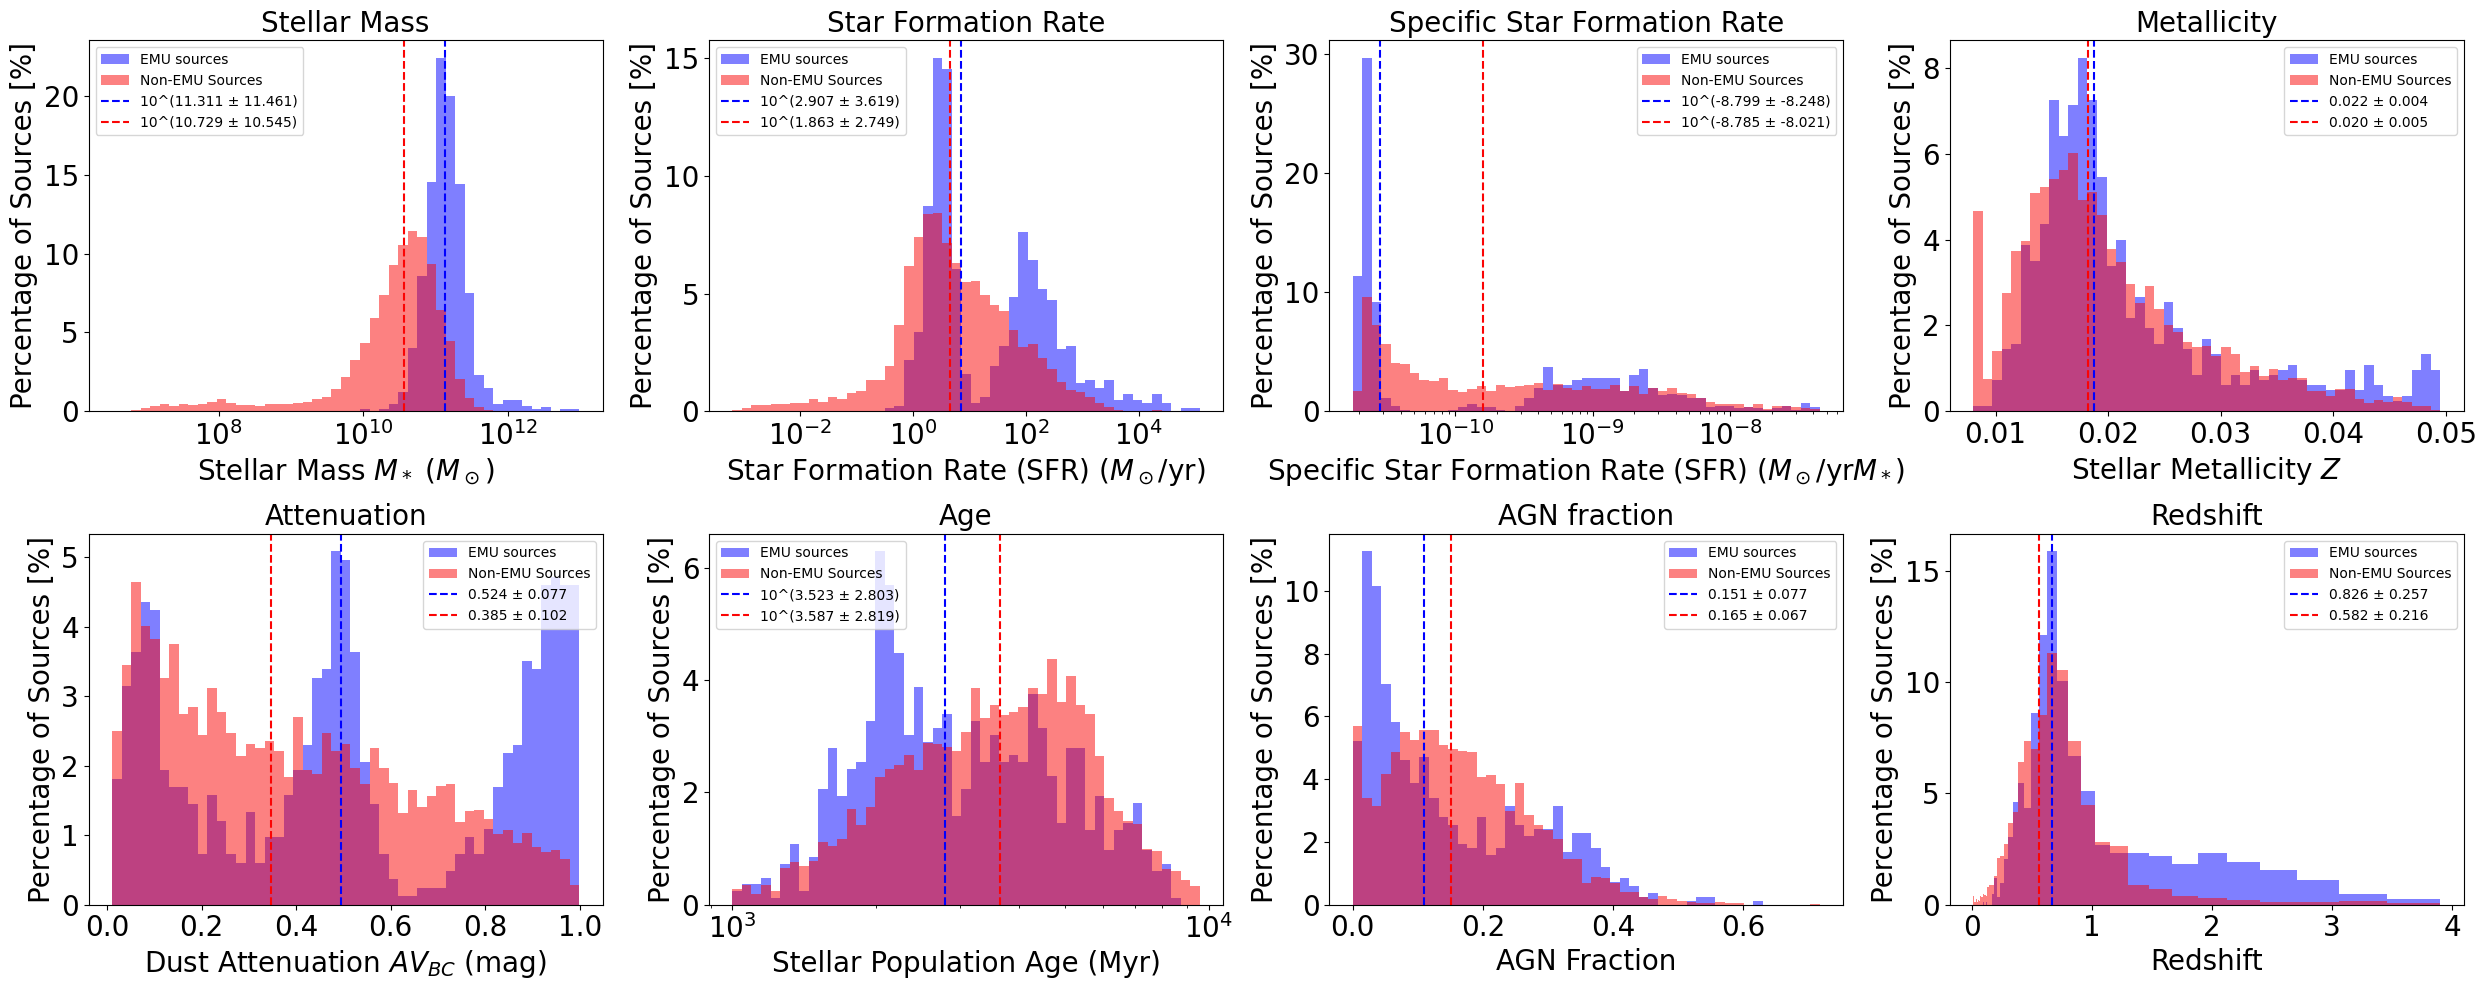

In [19]:
plot_log_hist_percent_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_samp_prots_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions= ['upper left', 'upper left', 'upper right', 'upper right','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(emu_avg_stellarmass), np.log10(emu_avg_sfr), np.log10(emu_avg_ssfr), emu_avg_metallicity, emu_avg_Av_BC, np.log10(emu_avg_age), emu_avg_AGN, emu_avg_red],
    errors1=[np.log10(emu_err_stellarmass), np.log10(emu_err_sfr), np.log10(emu_err_ssfr), emu_err_metallicity, emu_err_Av_BC, np.log10(emu_err_age), emu_err_AGN, emu_err_red],
    values2=[np.log10(nonemu_samp_prots_stellarmass), np.log10(nonemu_samp_prots_sfr), np.log10(nonemu_samp_prots_ssfr), nonemu_samp_prots_metallicity, nonemu_samp_prots_Av_BC, np.log10(nonemu_samp_prots_age), nonemu_samp_prots_AGN, nonemu_samp_prots_red],
    errors2=[np.log10(nonemu_samp_prots_err_stellarmass), np.log10(nonemu_samp_prots_err_sfr), np.log10(nonemu_samp_prots_err_ssfr), nonemu_samp_prots_err_metallicity, nonemu_samp_prots_err_Av_BC, np.log10(nonemu_samp_prots_err_age), nonemu_samp_prots_err_AGN, nonemu_samp_prots_err_red],

    color1='#0000ff',
    color2='#fb0404'
)

#### EMU sources vs Non-EMU (with the same distribution in the g magnitude)

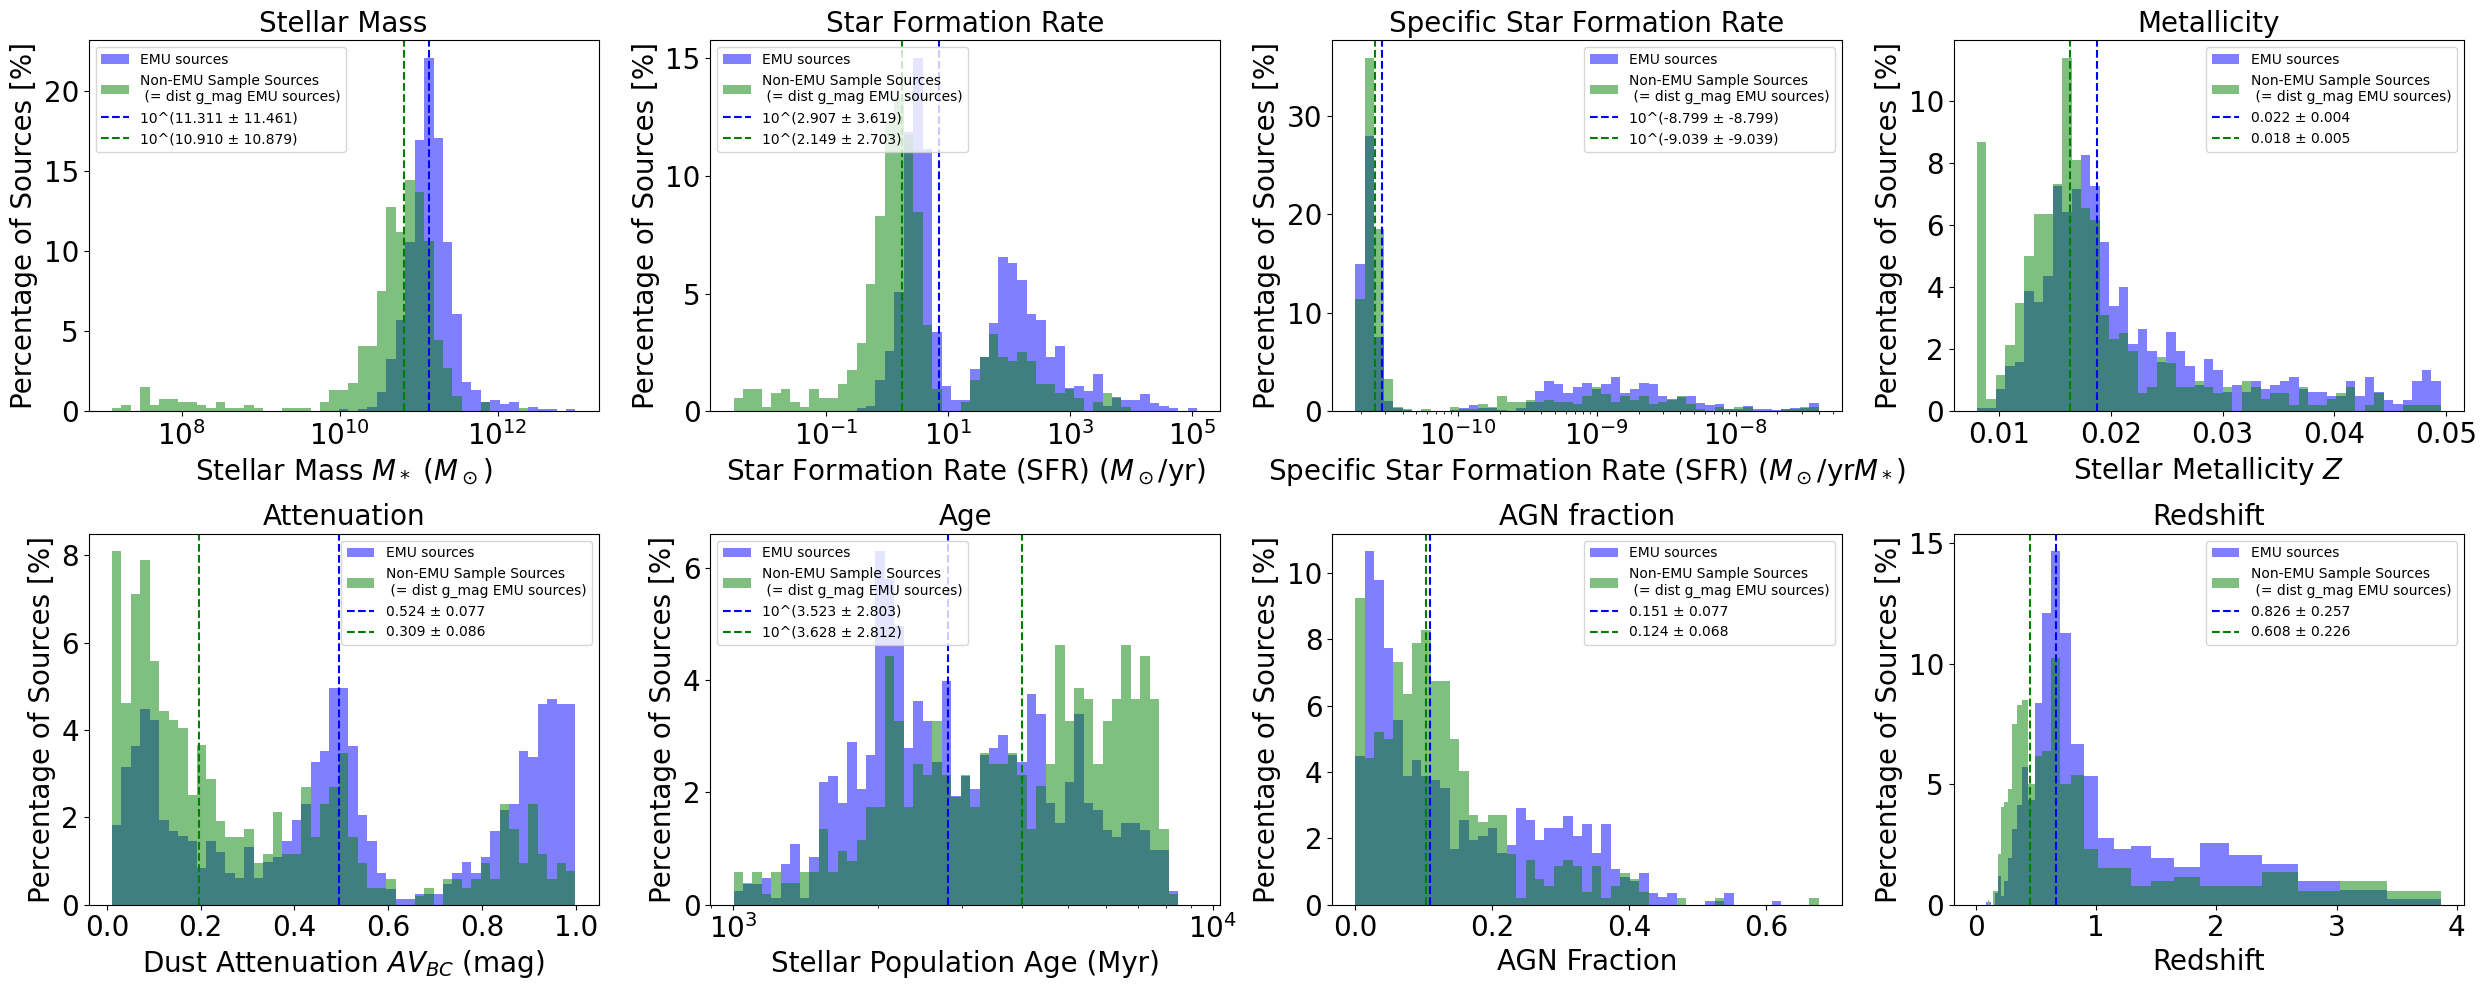

In [20]:
plot_log_hist_percent_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("EMU sources", "Non-EMU Sample Sources \n (= dist g_mag EMU sources)"),
    legend_positions= ['upper left', 'upper left', 'upper right', 'upper right','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(emu_avg_stellarmass), np.log10(emu_avg_sfr), np.log10(emu_avg_ssfr), emu_avg_metallicity, emu_avg_Av_BC, np.log10(emu_avg_age), emu_avg_AGN, emu_avg_red],
    errors1=[np.log10(emu_err_stellarmass), np.log10(emu_err_sfr), np.log10(emu_avg_ssfr), emu_err_metallicity, emu_err_Av_BC, np.log10(emu_err_age), emu_err_AGN, emu_err_red],
    values2=[np.log10(nonemu_avg_stellarmass), np.log10(nonemu_avg_sfr), np.log10(nonemu_avg_ssfr), nonemu_avg_metallicity, nonemu_avg_Av_BC, np.log10(nonemu_avg_age), avg_AGN, avg_red],
    errors2=[np.log10(nonemu_err_stellarmass), np.log10(nonemu_err_sfr), np.log10(nonemu_avg_ssfr), nonemu_err_metallicity, nonemu_err_Av_BC, np.log10(nonemu_err_age), err_AGN, err_red],
    color2='green'
)

#### Non-EMU sample vs Non-EMU prototypes

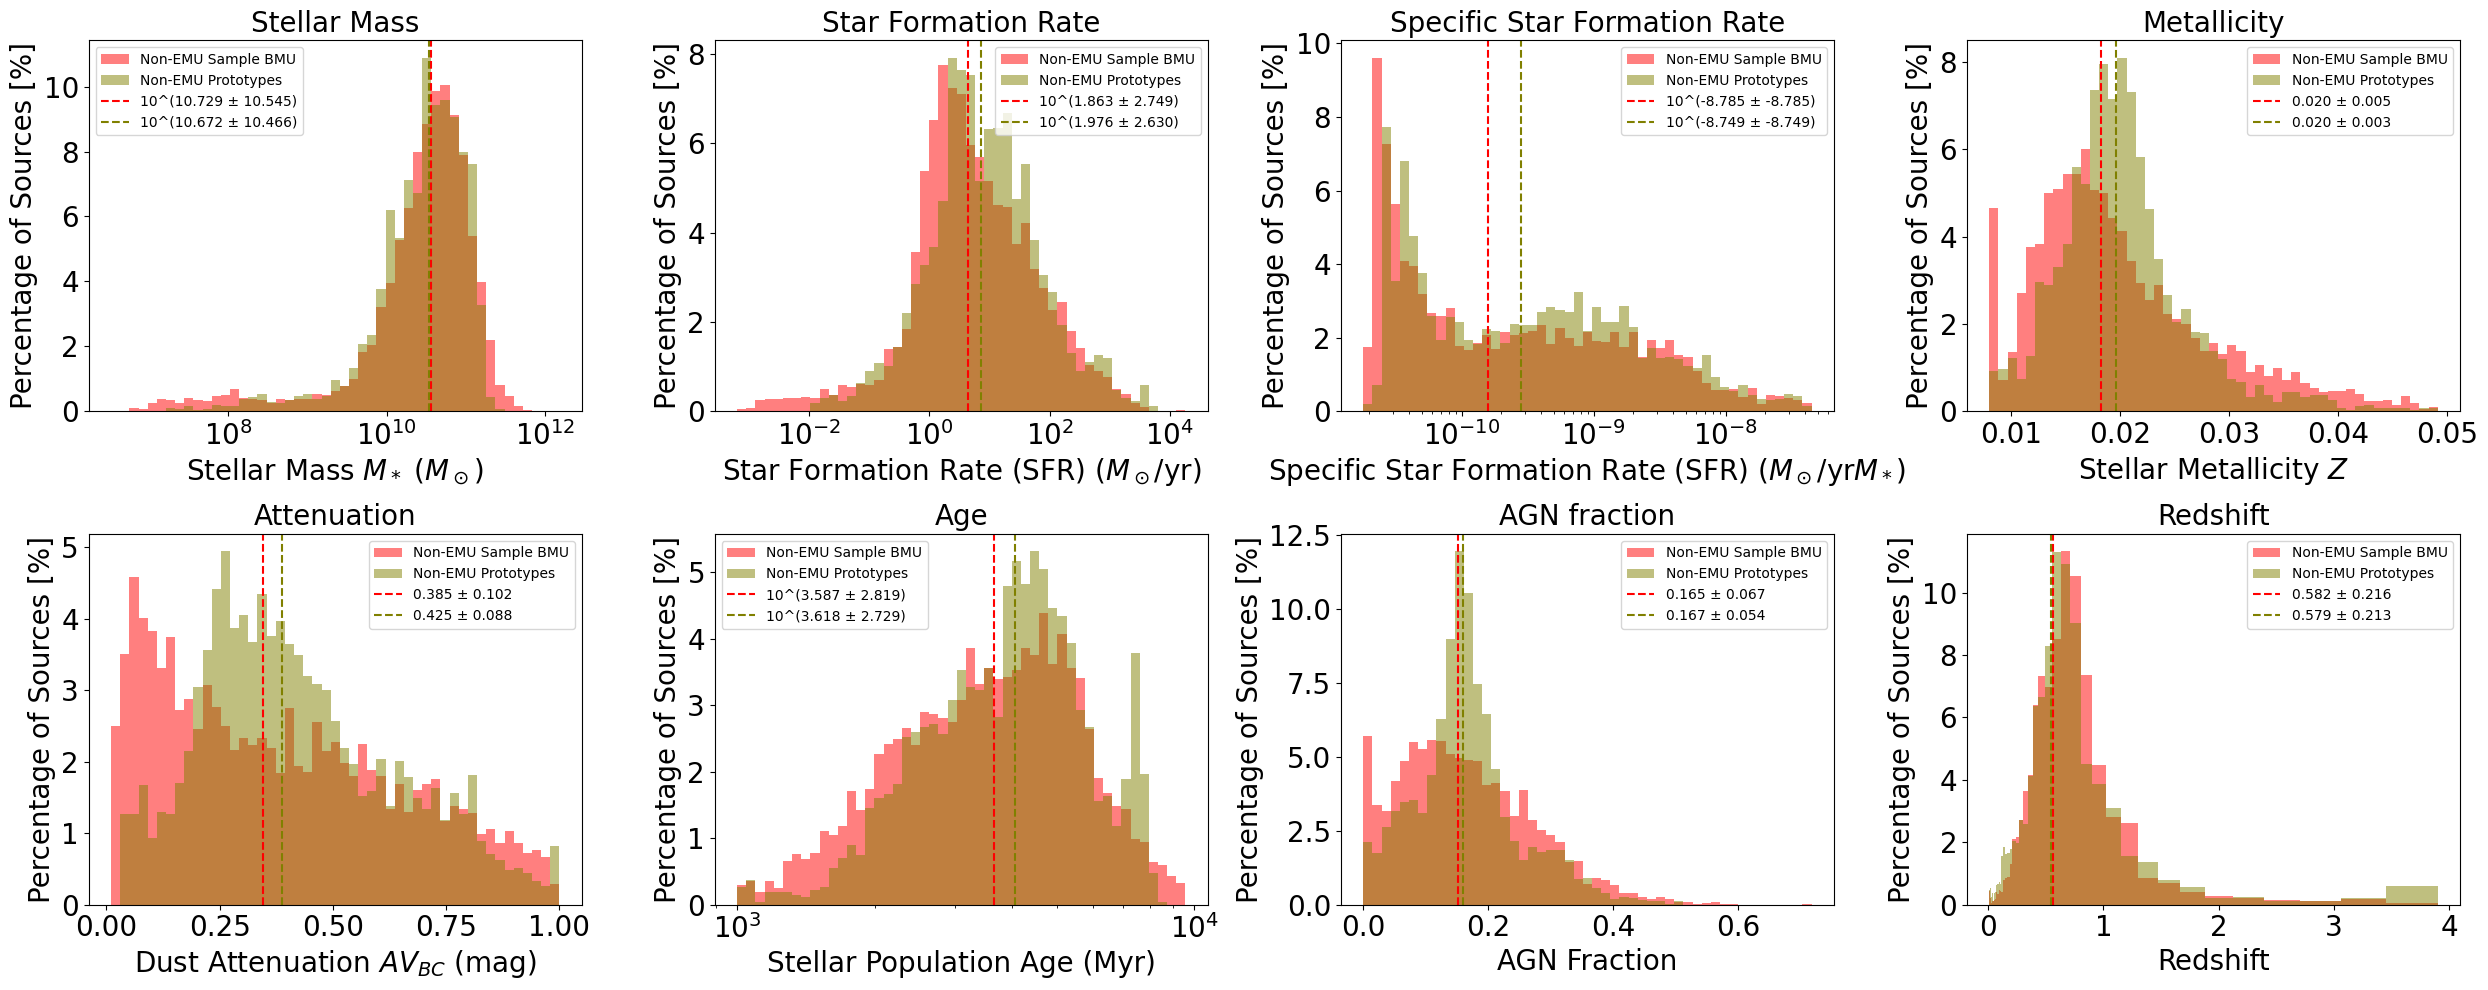

In [21]:
plot_log_hist_percent_2rows_sns(
    df1=nonemu_samp_prots_best,
    df2=nonemu_prototypes_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("Non-EMU Sample BMU", "Non-EMU Prototypes"),
    legend_positions= ['upper left', 'upper right', 'upper right', 'upper right','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(nonemu_samp_prots_stellarmass), np.log10(nonemu_samp_prots_sfr), np.log10(nonemu_samp_prots_ssfr), nonemu_samp_prots_metallicity, nonemu_samp_prots_Av_BC, np.log10(nonemu_samp_prots_age), nonemu_samp_prots_AGN, nonemu_samp_prots_red],
    errors1=[np.log10(nonemu_samp_prots_err_stellarmass), np.log10(nonemu_samp_prots_err_sfr), np.log10(nonemu_samp_prots_ssfr), nonemu_samp_prots_err_metallicity, nonemu_samp_prots_err_Av_BC, np.log10(nonemu_samp_prots_err_age), nonemu_samp_prots_err_AGN, nonemu_samp_prots_err_red],
    values2=[np.log10(nonemu_prots_stellarmass), np.log10(nonemu_prots_sfr), np.log10(nonemu_prots_ssfr), nonemu_prots_metallicity, nonemu_prots_Av_BC, np.log10(nonemu_prots_age), nonemu_prots_AGN, nonemu_prots_red],
    errors2=[np.log10(nonemu_prots_err_stellarmass), np.log10(nonemu_prots_err_sfr), np.log10(nonemu_prots_ssfr), nonemu_prots_err_metallicity, nonemu_prots_err_Av_BC, np.log10(nonemu_prots_err_age), nonemu_prots_err_AGN, nonemu_prots_err_red],
    color1='red',
    color2='olive'
)

#### Non-EMU vs Non-EMU (with the same distribution in the g magnitude)

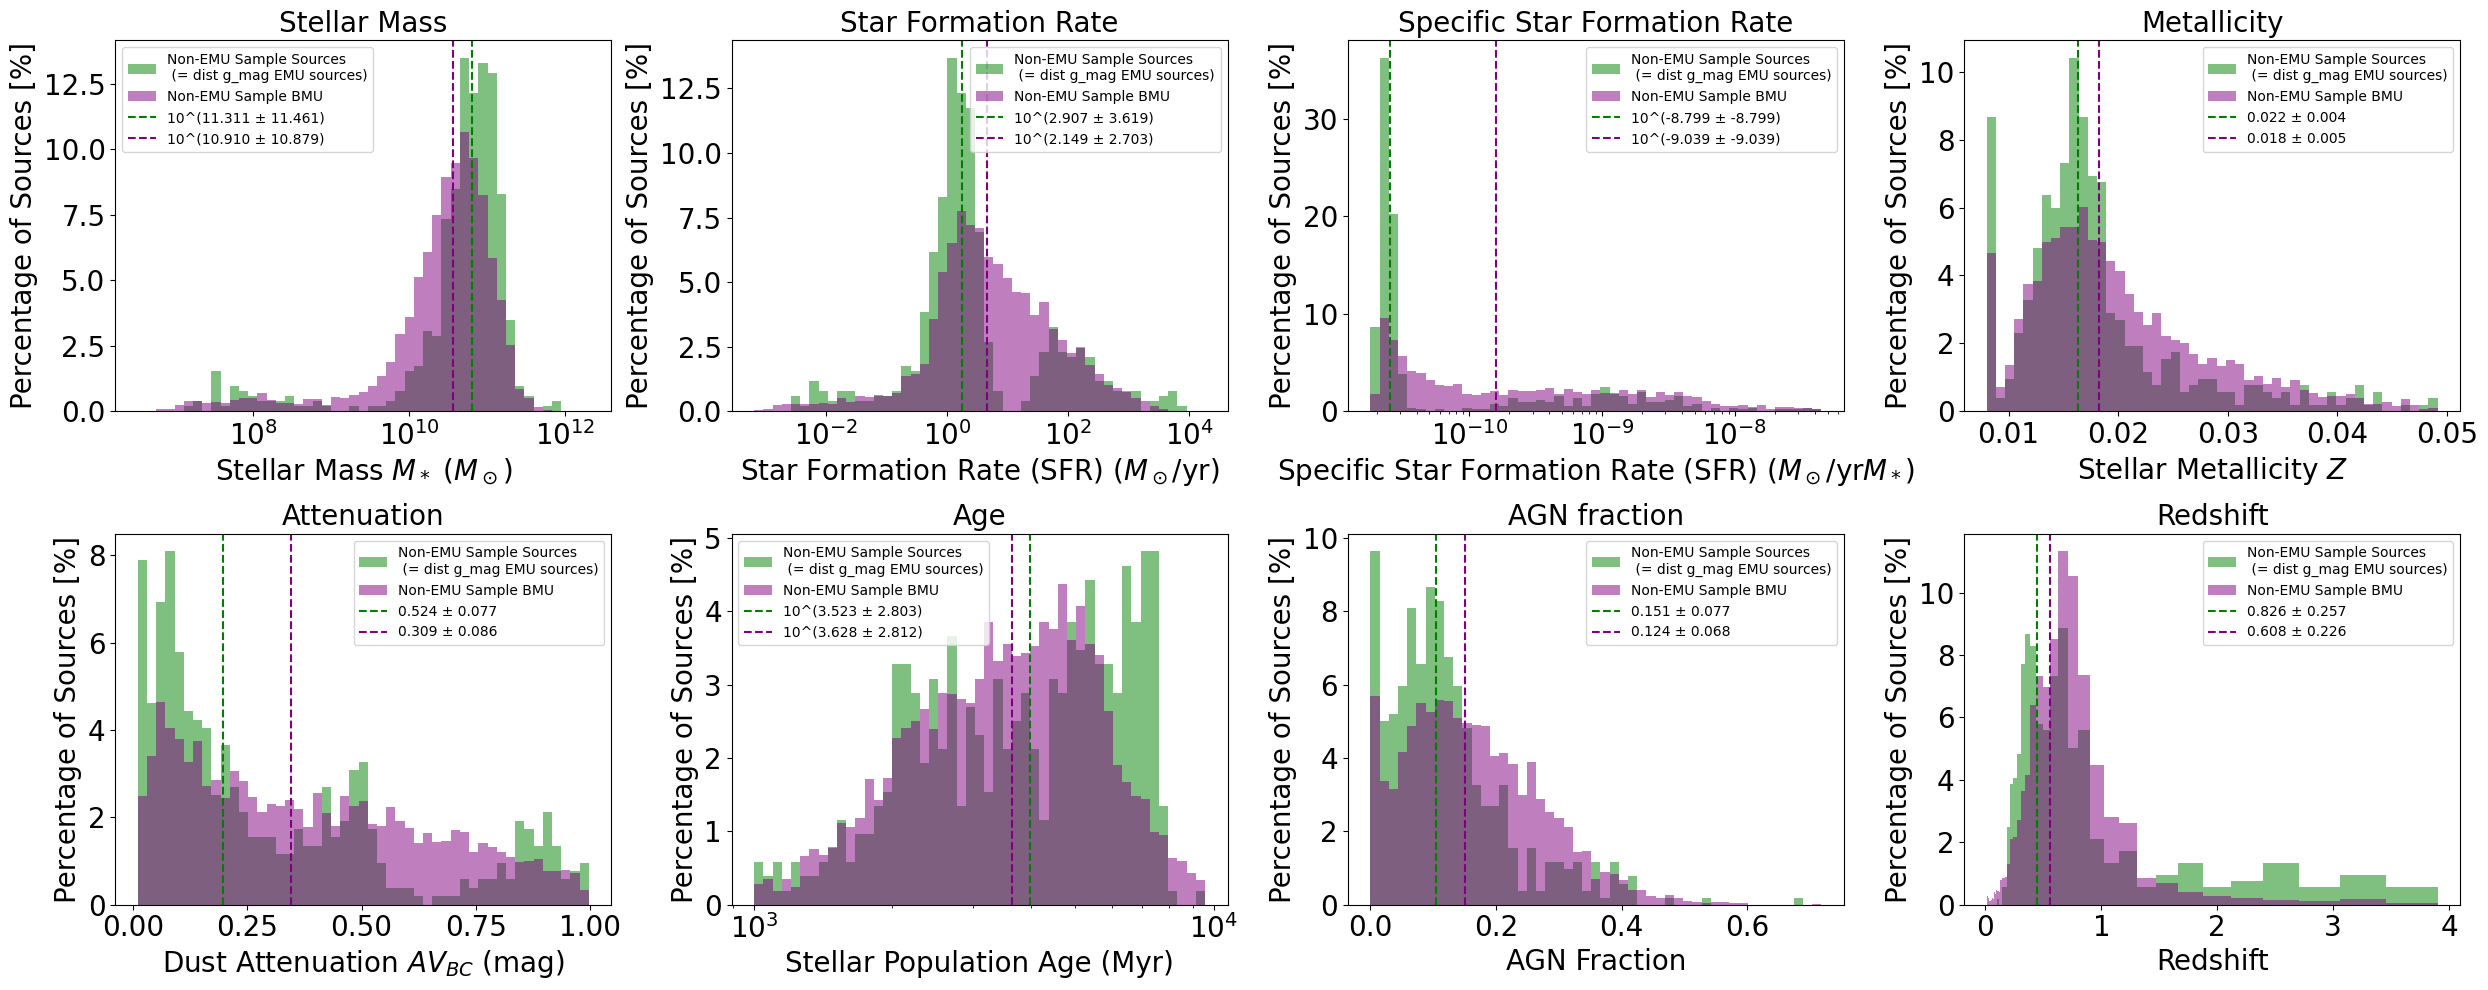

In [22]:
plot_log_hist_percent_2rows_sns(
    df1=nonemu_sources_best,
    df2=nonemu_samp_prots_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("Non-EMU Sample Sources \n (= dist g_mag EMU sources)", "Non-EMU Sample BMU"),
    legend_positions= ['upper left', 'upper right', 'upper right', 'upper right','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(emu_avg_stellarmass), np.log10(emu_avg_sfr), np.log10(emu_avg_ssfr), emu_avg_metallicity, emu_avg_Av_BC, np.log10(emu_avg_age), emu_avg_AGN, emu_avg_red],
    errors1=[np.log10(emu_err_stellarmass), np.log10(emu_err_sfr), np.log10(emu_avg_ssfr), emu_err_metallicity, emu_err_Av_BC, np.log10(emu_err_age), emu_err_AGN, emu_err_red],
    values2=[np.log10(nonemu_avg_stellarmass), np.log10(nonemu_avg_sfr), np.log10(nonemu_avg_ssfr), nonemu_avg_metallicity, nonemu_avg_Av_BC, np.log10(nonemu_avg_age), avg_AGN, avg_red],
    errors2=[np.log10(nonemu_err_stellarmass), np.log10(nonemu_err_sfr), np.log10(nonemu_avg_ssfr), nonemu_err_metallicity, nonemu_err_Av_BC, np.log10(nonemu_err_age), err_AGN, err_red],
    color1= 'green',
    color2= 'purple'
)

### Density plot of EMU and non-EMU sources

In [23]:
def plot_log_kde_2rows_sns(
    df1, df2, columns, x_labels, legend_positions, labels, titles, values1, values2, errors1, errors2, 
    figsize=(25, 10),
    title_fontsize=20,
    xlabel_fontsize=20,
    ylabel_fontsize=20,
    xtick_fontsize=15,
    ytick_fontsize=15,
    legend_fontsize=10,
    color1='#3a4dc6',
    color2='#cb3b32',
):
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]
        
        data1 = df1[col].dropna()
        data2 = df2[col].dropna()

        if 'bayes.stellar.metallicity' in col:
            # Metallicity specific settings (0.01, 0.02, etc.)
            sns.kdeplot(data1, ax=ax, label=labels[0], color=color1, fill=True, common_norm=False)
            sns.kdeplot(data2, ax=ax, label=labels[1], color=color2, fill=True, common_norm=False)
            
            ticks = np.arange(0, 0.051, 0.01)
            ax.set_xticks(ticks)
            ax.set_xticklabels([f'{x:.2f}' for x in ticks])
            
            ax.axvline(data1.median(), color=color1, linestyle='dashed', linewidth=1.5, 
                      label=f'{values1[i]:.3f} ± {errors1[i]:.3f}')
            ax.axvline(data2.median(), color=color2, linestyle='dashed', linewidth=1.5, 
                      label=f'{values2[i]:.3f} ± {errors2[i]:.3f}')

        elif 'bayes.attenuation.Av_BC' in col:
            # Dust attenuation specific settings (0.0, 0.2, etc.)
            sns.kdeplot(data1, ax=ax, label=labels[0], color=color1, fill=True, common_norm=False)
            sns.kdeplot(data2, ax=ax, label=labels[1], color=color2, fill=True, common_norm=False)
            
            ticks = np.arange(0, 1.1, 0.2)
            ax.set_xticks(ticks)
            ax.set_xticklabels([f'{x:.1f}' for x in ticks])
            
            ax.axvline(data1.median(), color=color1, linestyle='dashed', linewidth=1.5, 
                      label=f'{values1[i]:.2f} ± {errors1[i]:.2f}')
            ax.axvline(data2.median(), color=color2, linestyle='dashed', linewidth=1.5, 
                      label=f'{values2[i]:.2f} ± {errors2[i]:.2f}')

        elif 'bayes.agn.fracAGN' in col:
            # AGN fraction specific settings (0.0, 0.2, etc.)
            sns.kdeplot(data1, ax=ax, label=labels[0], color=color1, fill=True, common_norm=False)
            sns.kdeplot(data2, ax=ax, label=labels[1], color=color2, fill=True, common_norm=False)
            
            ticks = np.arange(0, 0.61, 0.2)
            ax.set_xticks(ticks)
            ax.set_xticklabels([f'{x:.1f}' for x in ticks])
            
            ax.axvline(data1.median(), color=color1, linestyle='dashed', linewidth=1.5, 
                      label=f'{values1[i]:.2f} ± {errors1[i]:.2f}')
            ax.axvline(data2.median(), color=color2, linestyle='dashed', linewidth=1.5, 
                      label=f'{values2[i]:.2f} ± {errors2[i]:.2f}')

        elif 'bayes.universe.redshift' in col:
            # Redshift specific settings (0, 1, 2, etc.)
            sns.kdeplot(data1, ax=ax, label=labels[0], color=color1, fill=True, common_norm=False)
            sns.kdeplot(data2, ax=ax, label=labels[1], color=color2, fill=True, common_norm=False)
            
            ticks = np.arange(0, 5, 1)
            ax.set_xticks(ticks)
            ax.set_xticklabels([f'{int(x)}' for x in ticks])
            
            ax.axvline(data1.median(), color=color1, linestyle='dashed', linewidth=1.5, 
                      label=f'{values1[i]:.1f} ± {errors1[i]:.1f}')
            ax.axvline(data2.median(), color=color2, linestyle='dashed', linewidth=1.5, 
                      label=f'{values2[i]:.1f} ± {errors2[i]:.1f}')

        else:
            # Log-scale plots for other parameters
            data1 = data1[data1 > 0]
            data2 = data2[data2 > 0]
            
            log_data1 = np.log10(data1)
            log_data2 = np.log10(data2)
            sns.kdeplot(log_data1, ax=ax, label=labels[0], color=color1, fill=True, common_norm=False)
            sns.kdeplot(log_data2, ax=ax, label=labels[1], color=color2, fill=True, common_norm=False)
            
            min_log = np.floor(log_data1.min()) if len(log_data1) > 0 else 0
            max_log = np.ceil(log_data2.max()) if len(log_data2) > 0 else 1
            if len(log_data1) > 0 and len(log_data2) > 0:
                min_log = min(np.floor(log_data1.min()), np.floor(log_data2.min()))
                max_log = max(np.ceil(log_data1.max()), np.ceil(log_data2.max()))
            
            if min_log == max_log:
                min_log -= 1
                max_log += 1
            
            exponent_range = max_log - min_log
            if exponent_range <= 10:
                ticks = np.arange(min_log, max_log + 1)
            else:
                step = max(1, exponent_range // 10)
                ticks = np.arange(min_log, max_log + step, step)
            
            ax.set_xticks(ticks)
            
            tick_labels = []
            for x in ticks:
                if x == 0:
                    tick_labels.append('$1$')
                elif x == 1:
                    tick_labels.append('$10$')
                else:
                    tick_labels.append(f'$10^{{{int(x)}}}$')
            
            ax.set_xticklabels(tick_labels)
            ax.set_xlim(min_log, max_log)
            
            if len(data1) > 0:
                ax.axvline(np.log10(data1.median()), color=color1, linestyle='dashed', linewidth=1.5, 
                          label=f'10^{{{values1[i]:.3f}±{errors1[i]:.3f}}}')
            if len(data2) > 0:
                ax.axvline(np.log10(data2.median()), color=color2, linestyle='dashed', linewidth=1.5, 
                          label=f'10^{{{values2[i]:.3f}±{errors2[i]:.3f}}}')

        ax.set_title(titles[i], fontsize=title_fontsize)
        ax.set_xlabel(x_labels[i], fontsize=xlabel_fontsize)
        ax.set_ylabel('Density', fontsize=ylabel_fontsize)
        ax.tick_params(axis='x', labelsize=xtick_fontsize)
        ax.tick_params(axis='y', labelsize=ytick_fontsize)
        ax.legend(loc=legend_positions[i], fontsize=legend_fontsize)

    for j in range(n, nrows * ncols):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.savefig("/home/polaris/Lab_Astro/cigale_kde.png", dpi=72)
    plt.show()

#### EMU sources vs Non-EMU

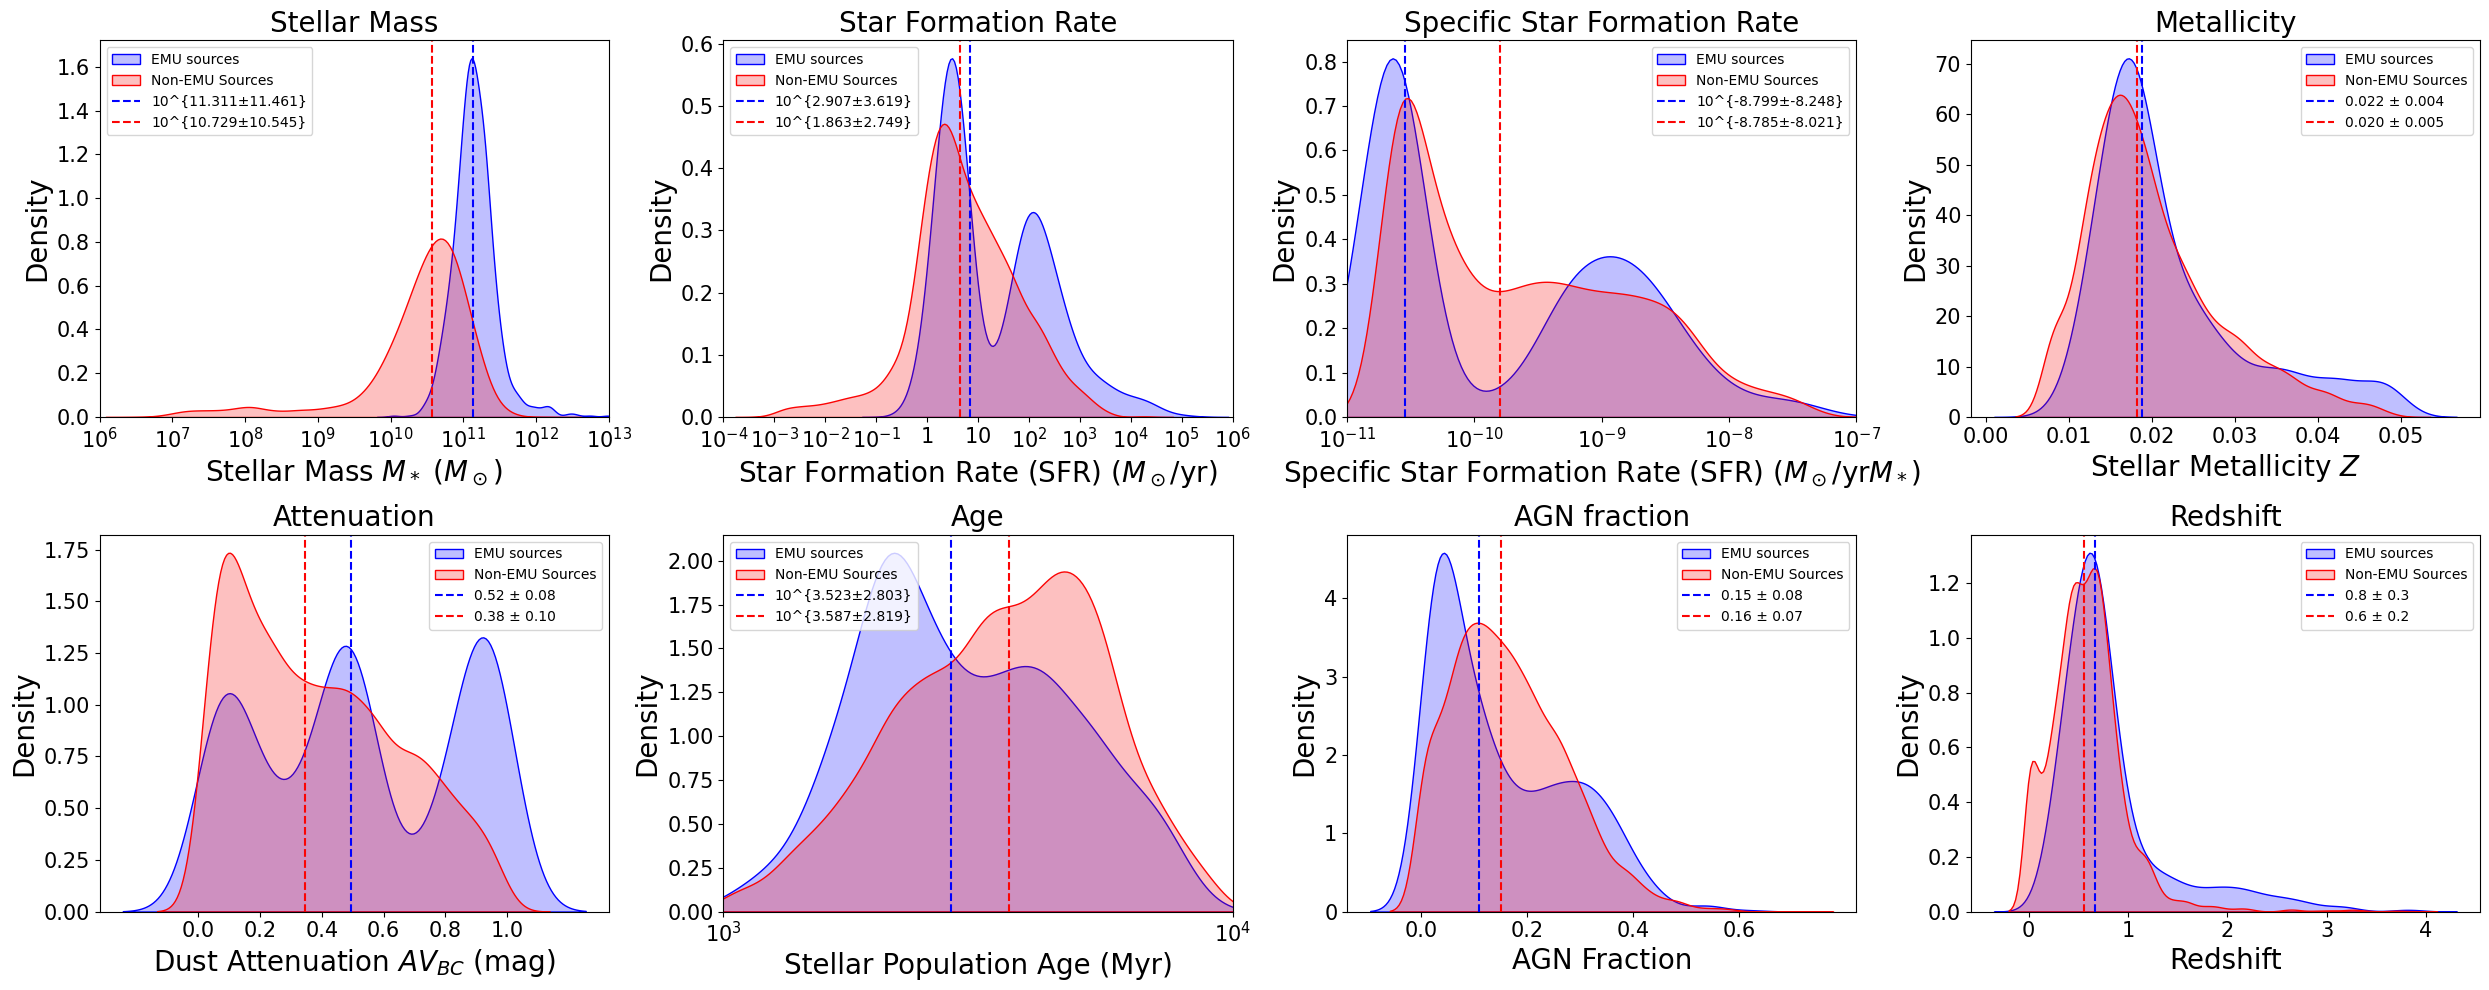

In [24]:
plot_log_kde_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_samp_prots_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions= ['upper left', 'upper left', 'upper right', 'upper right','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(emu_avg_stellarmass), np.log10(emu_avg_sfr), np.log10(emu_avg_ssfr), emu_avg_metallicity, emu_avg_Av_BC, np.log10(emu_avg_age), emu_avg_AGN, emu_avg_red],
    errors1=[np.log10(emu_err_stellarmass), np.log10(emu_err_sfr), np.log10(emu_err_ssfr), emu_err_metallicity, emu_err_Av_BC, np.log10(emu_err_age), emu_err_AGN, emu_err_red],
    values2=[np.log10(nonemu_samp_prots_stellarmass), np.log10(nonemu_samp_prots_sfr), np.log10(nonemu_samp_prots_ssfr), nonemu_samp_prots_metallicity, nonemu_samp_prots_Av_BC, np.log10(nonemu_samp_prots_age), nonemu_samp_prots_AGN, nonemu_samp_prots_red],
    errors2=[np.log10(nonemu_samp_prots_err_stellarmass), np.log10(nonemu_samp_prots_err_sfr), np.log10(nonemu_samp_prots_err_ssfr), nonemu_samp_prots_err_metallicity, nonemu_samp_prots_err_Av_BC, np.log10(nonemu_samp_prots_err_age), nonemu_samp_prots_err_AGN, nonemu_samp_prots_err_red],
    color1='#0000ff',
    color2='#fb0404'
    # color1='#7B68EE',
    # color2='#DC143C'
)

#### Non-EMU vs Non-EMU (with the same distribution in the g magnitude)

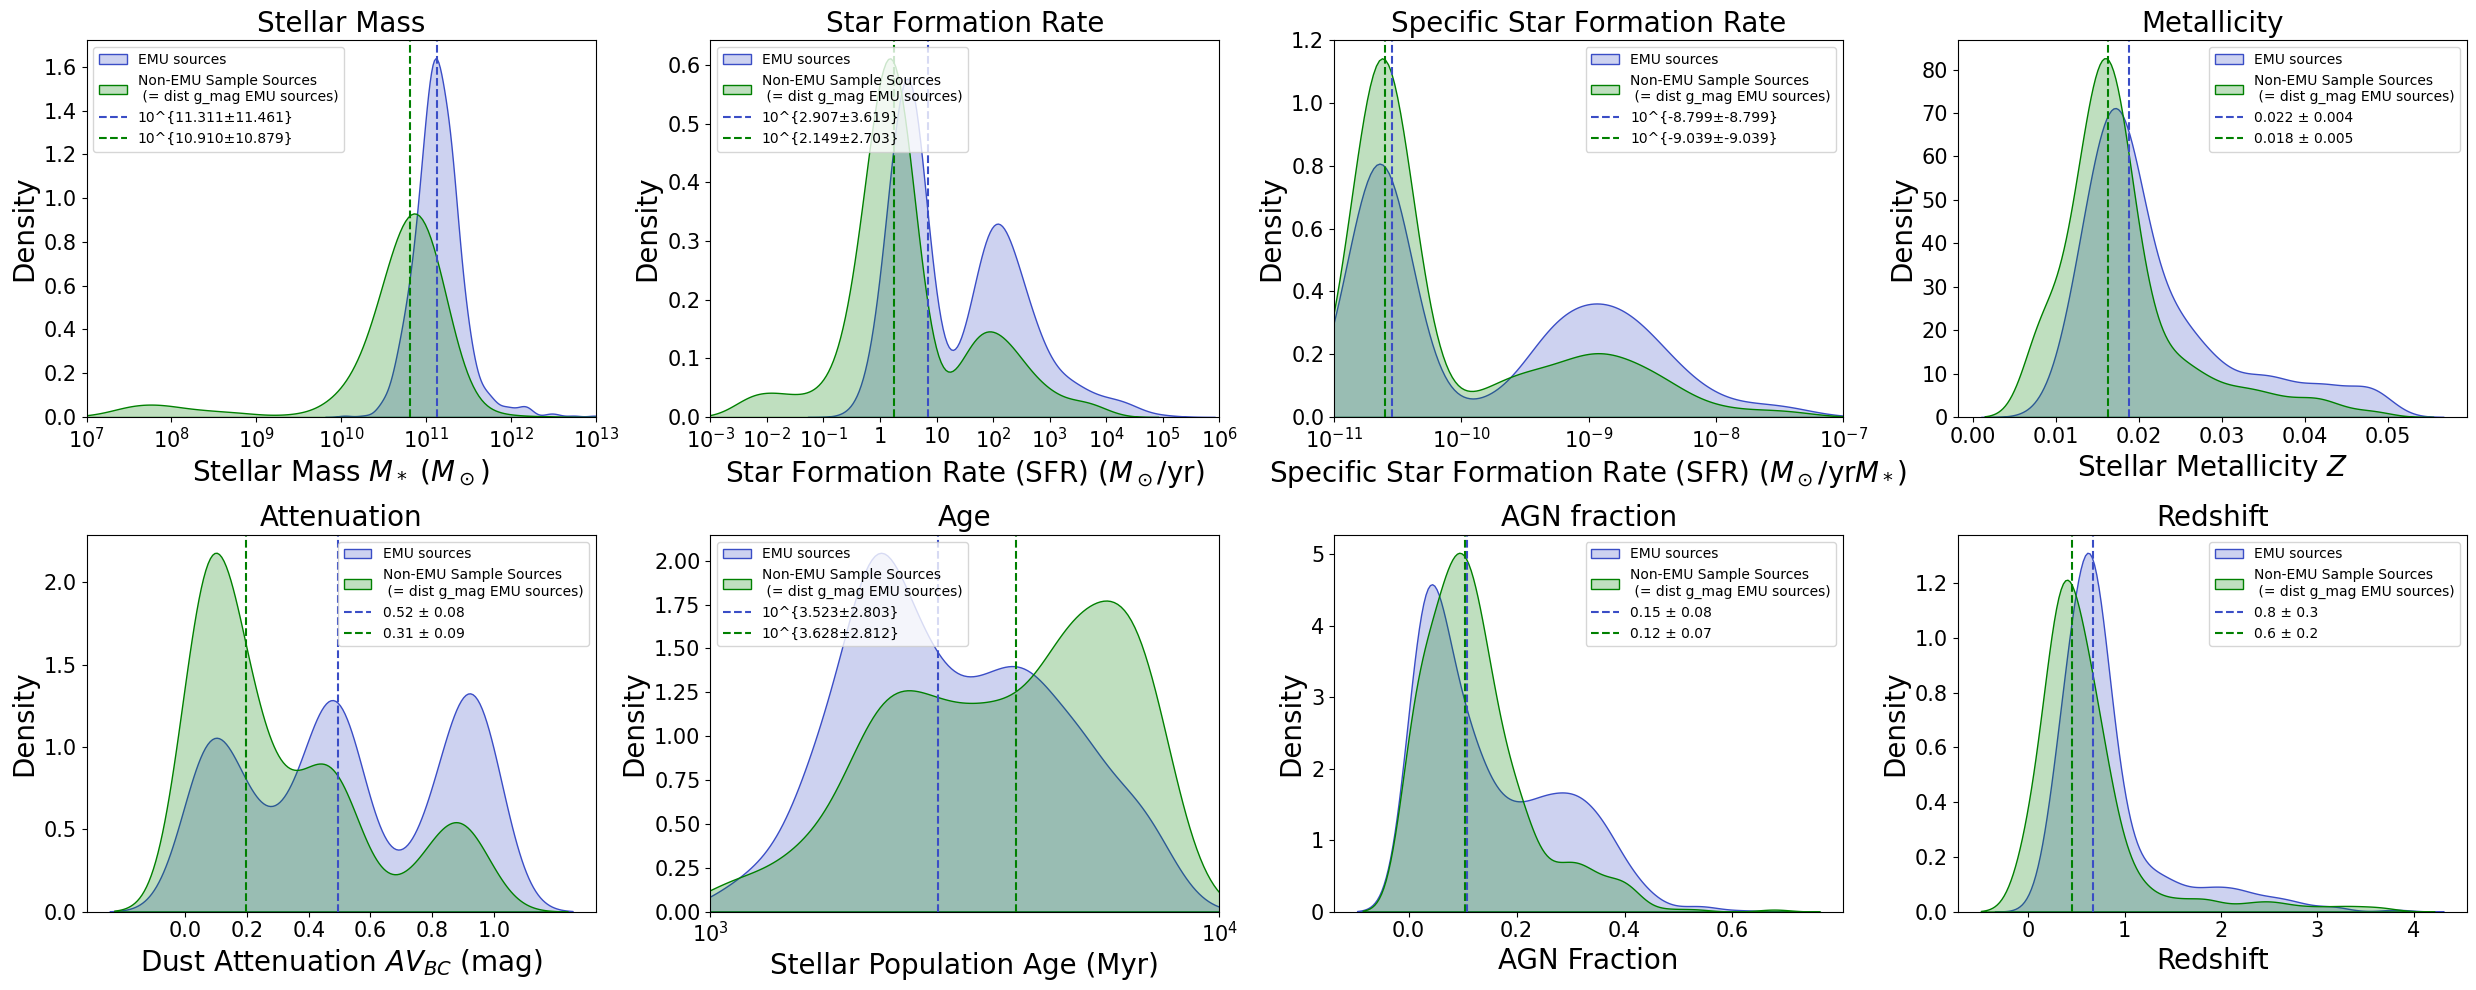

In [25]:
plot_log_kde_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("EMU sources", "Non-EMU Sample Sources \n (= dist g_mag EMU sources)"),
    legend_positions= ['upper left', 'upper left', 'upper right', 'upper right','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(emu_avg_stellarmass), np.log10(emu_avg_sfr), np.log10(emu_avg_ssfr), emu_avg_metallicity, emu_avg_Av_BC, np.log10(emu_avg_age), emu_avg_AGN, emu_avg_red],
    errors1=[np.log10(emu_err_stellarmass), np.log10(emu_err_sfr), np.log10(emu_avg_ssfr), emu_err_metallicity, emu_err_Av_BC, np.log10(emu_err_age), emu_err_AGN, emu_err_red],
    values2=[np.log10(nonemu_avg_stellarmass), np.log10(nonemu_avg_sfr), np.log10(nonemu_avg_ssfr), nonemu_avg_metallicity, nonemu_avg_Av_BC, np.log10(nonemu_avg_age), avg_AGN, avg_red],
    errors2=[np.log10(nonemu_err_stellarmass), np.log10(nonemu_err_sfr), np.log10(nonemu_avg_ssfr), nonemu_err_metallicity, nonemu_err_Av_BC, np.log10(nonemu_err_age), err_AGN, err_red],
    color2='green'
)

#### Non-EMU sample vs Non-EMU prototypes

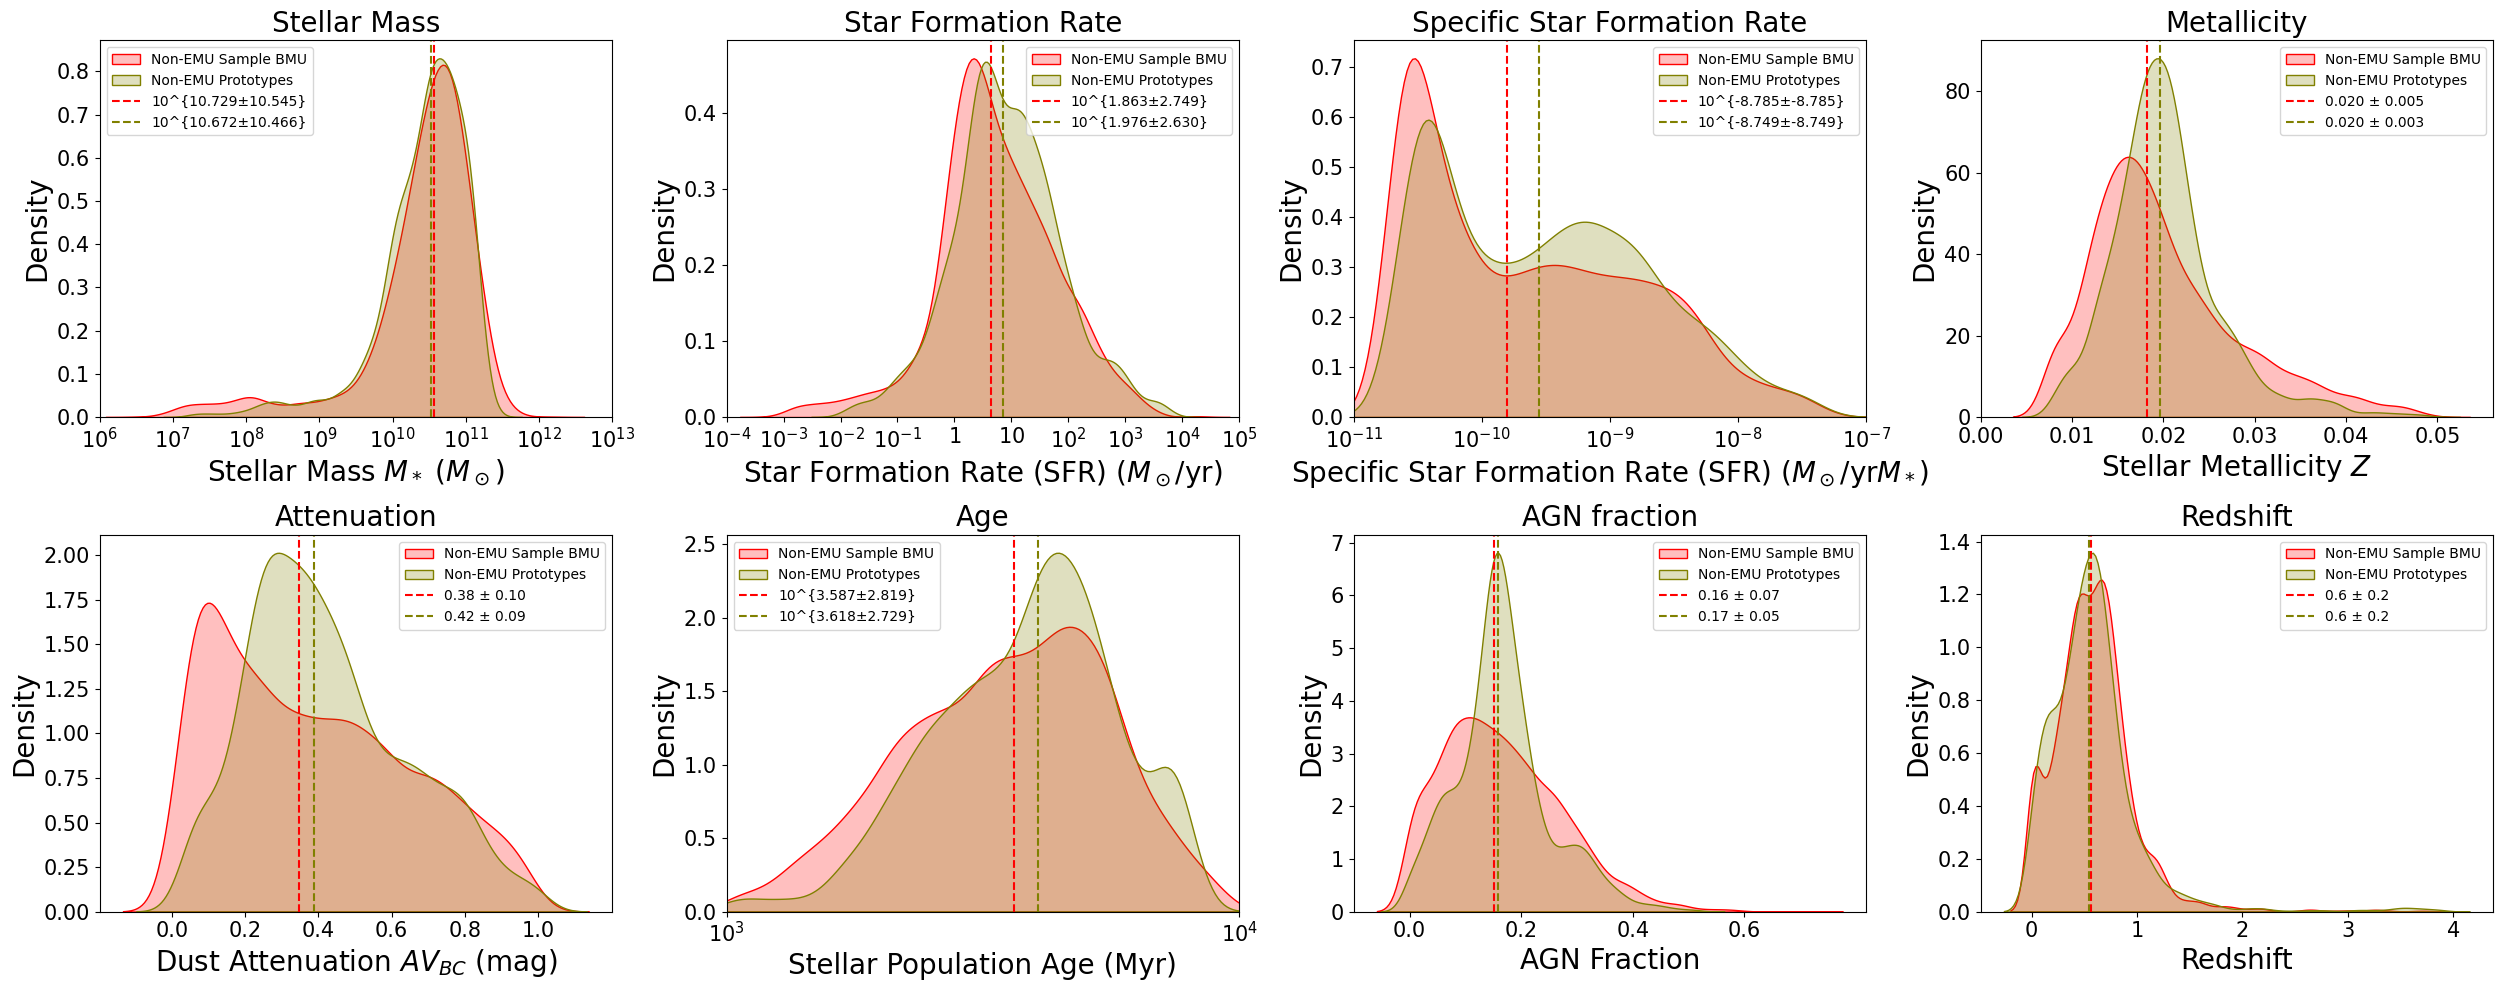

In [26]:
plot_log_kde_2rows_sns(
    df1=nonemu_samp_prots_best,
    df2=nonemu_prototypes_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("Non-EMU Sample BMU", "Non-EMU Prototypes"),
    legend_positions= ['upper left', 'upper right', 'upper right', 'upper right','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(nonemu_samp_prots_stellarmass), np.log10(nonemu_samp_prots_sfr), np.log10(nonemu_samp_prots_ssfr), nonemu_samp_prots_metallicity, nonemu_samp_prots_Av_BC, np.log10(nonemu_samp_prots_age), nonemu_samp_prots_AGN, nonemu_samp_prots_red],
    errors1=[np.log10(nonemu_samp_prots_err_stellarmass), np.log10(nonemu_samp_prots_err_sfr), np.log10(nonemu_samp_prots_ssfr), nonemu_samp_prots_err_metallicity, nonemu_samp_prots_err_Av_BC, np.log10(nonemu_samp_prots_err_age), nonemu_samp_prots_err_AGN, nonemu_samp_prots_err_red],
    values2=[np.log10(nonemu_prots_stellarmass), np.log10(nonemu_prots_sfr), np.log10(nonemu_prots_ssfr), nonemu_prots_metallicity, nonemu_prots_Av_BC, np.log10(nonemu_prots_age), nonemu_prots_AGN, nonemu_prots_red],
    errors2=[np.log10(nonemu_prots_err_stellarmass), np.log10(nonemu_prots_err_sfr), np.log10(nonemu_prots_ssfr), nonemu_prots_err_metallicity, nonemu_prots_err_Av_BC, np.log10(nonemu_prots_err_age), nonemu_prots_err_AGN, nonemu_prots_err_red],
    color1='red',
    color2='olive'
)

#### Non-EMU vs Non-EMU (with the same distribution in the g magnitude)

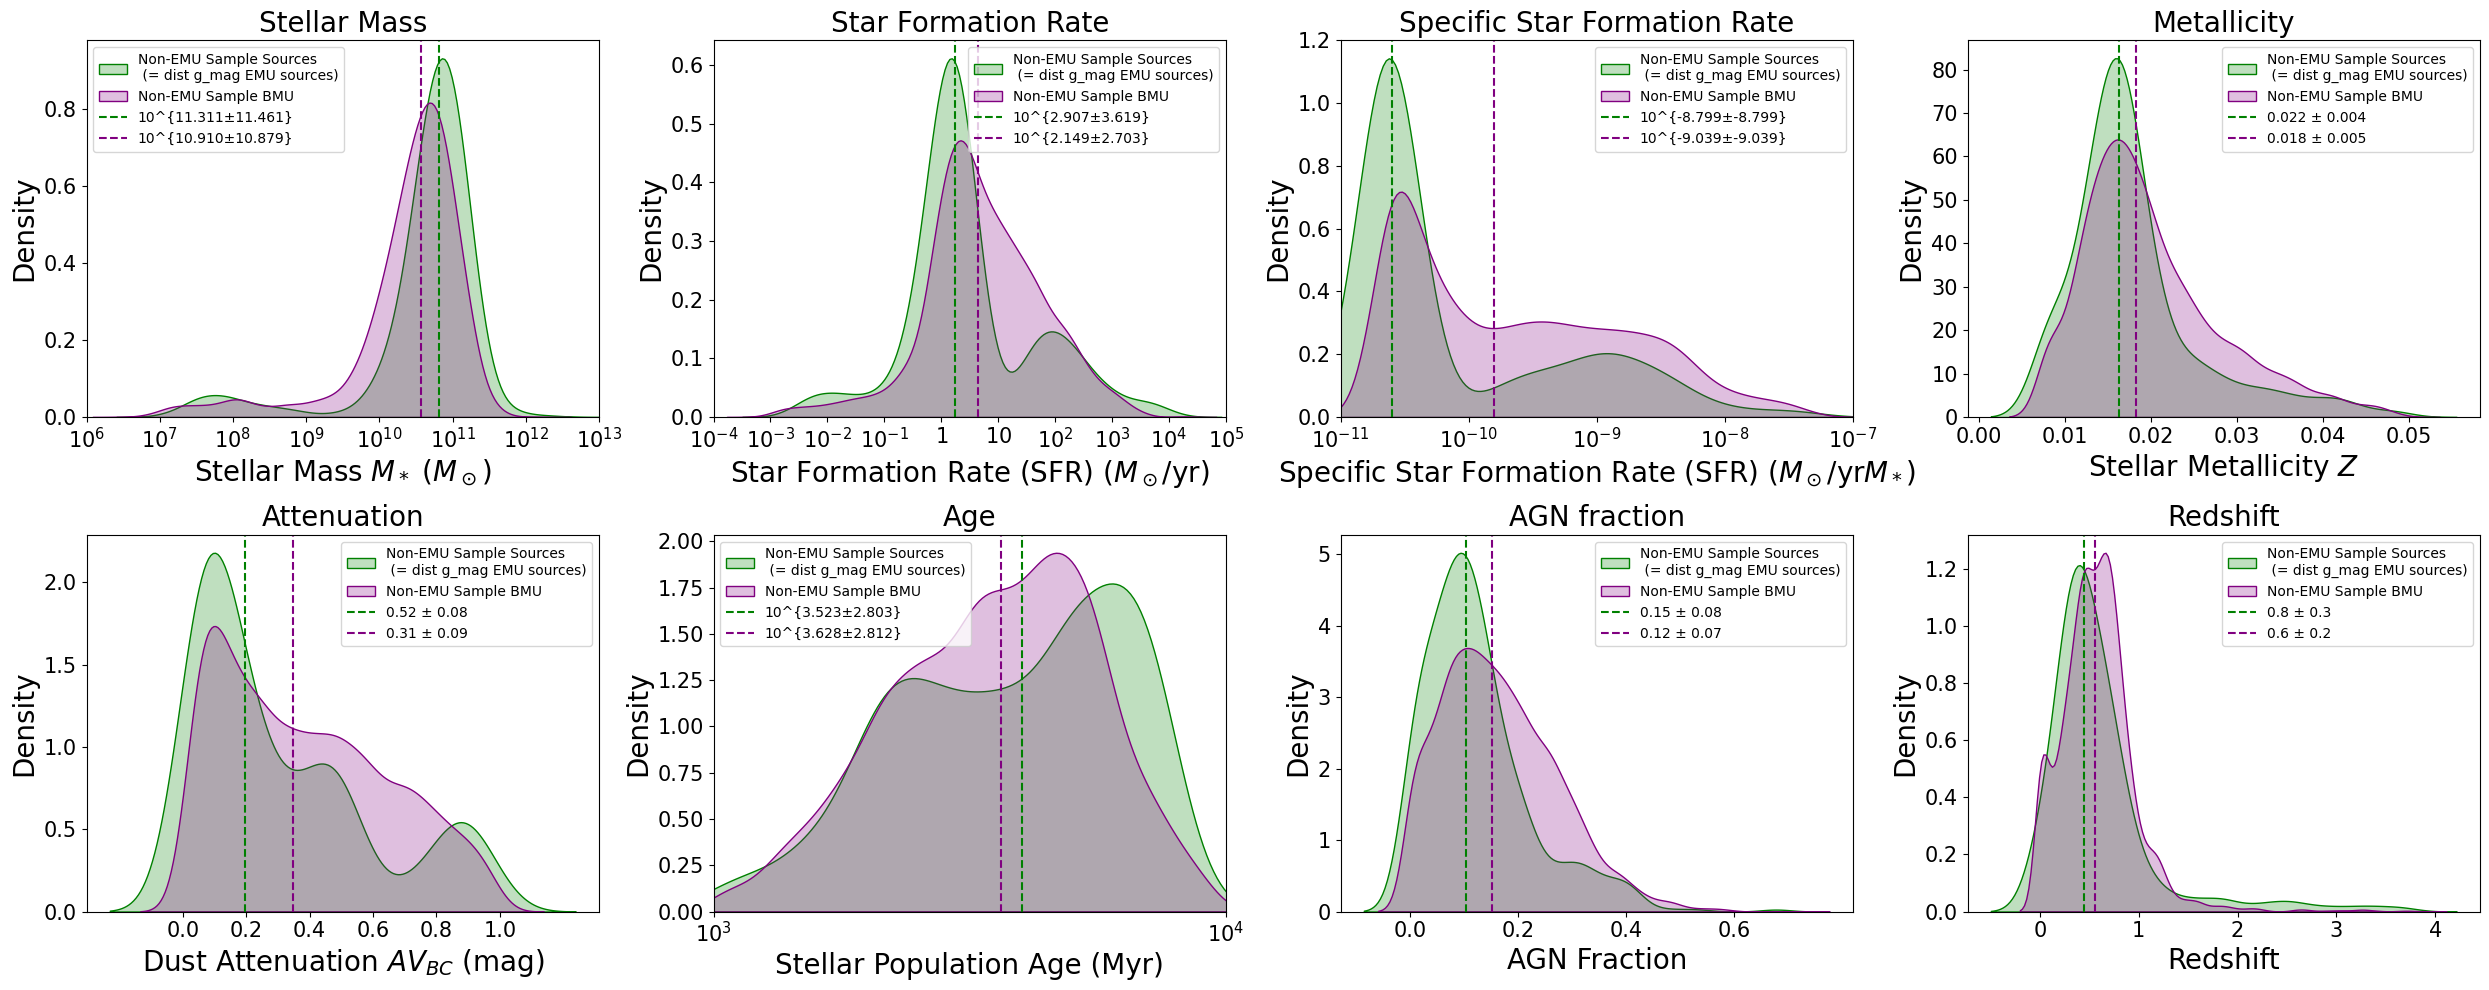

In [27]:
plot_log_kde_2rows_sns(
    df1=nonemu_sources_best,
    df2=nonemu_samp_prots_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("Non-EMU Sample Sources \n (= dist g_mag EMU sources)", "Non-EMU Sample BMU"),
    legend_positions= ['upper left', 'upper right', 'upper right', 'upper right','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(emu_avg_stellarmass), np.log10(emu_avg_sfr), np.log10(emu_avg_ssfr), emu_avg_metallicity, emu_avg_Av_BC, np.log10(emu_avg_age), emu_avg_AGN, emu_avg_red],
    errors1=[np.log10(emu_err_stellarmass), np.log10(emu_err_sfr), np.log10(emu_avg_ssfr), emu_err_metallicity, emu_err_Av_BC, np.log10(emu_err_age), emu_err_AGN, emu_err_red],
    values2=[np.log10(nonemu_avg_stellarmass), np.log10(nonemu_avg_sfr), np.log10(nonemu_avg_ssfr), nonemu_avg_metallicity, nonemu_avg_Av_BC, np.log10(nonemu_avg_age), avg_AGN, avg_red],
    errors2=[np.log10(nonemu_err_stellarmass), np.log10(nonemu_err_sfr), np.log10(nonemu_avg_ssfr), nonemu_err_metallicity, nonemu_err_Av_BC, np.log10(nonemu_err_age), err_AGN, err_red],
    color1= 'green',
    color2= 'purple'
)

## Star Formation Main Sequence for EMU and Non-EMU sources

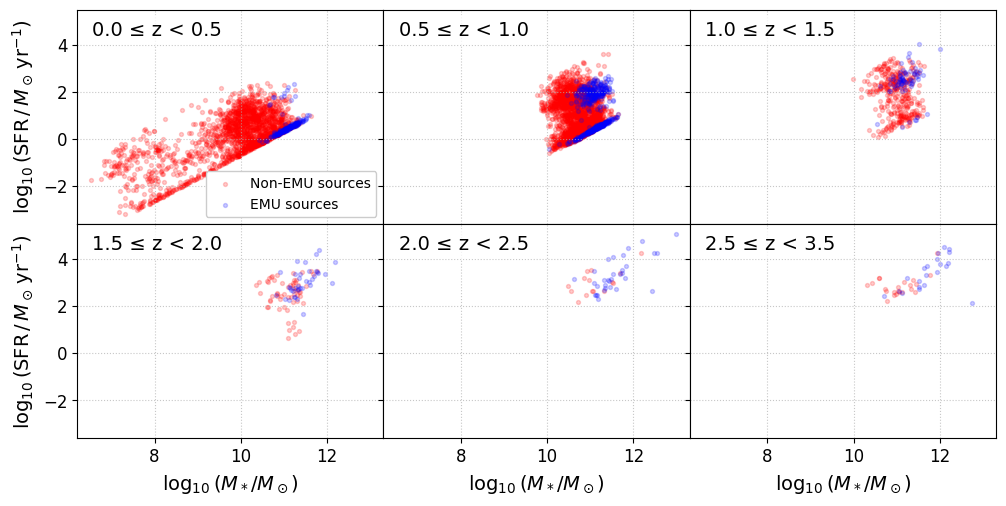

In [28]:
bins = [(0.0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, 3.5)]

# Calculate global axis limits
x_min = min(emu_sources_best['log_stellar_mass'].min(), nonemu_samp_prots_best['log_stellar_mass'].min())
x_max = max(emu_sources_best['log_stellar_mass'].max(), nonemu_samp_prots_best['log_stellar_mass'].max())
y_min = min(emu_sources_best['log_sfr'].min(), nonemu_samp_prots_best['log_sfr'].min())
y_max = max(emu_sources_best['log_sfr'].max(), nonemu_samp_prots_best['log_sfr'].max())

# Add padding
x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (y_max - y_min)
xlim = (x_min - x_pad, x_max + x_pad)
ylim = (y_min - y_pad, y_max + y_pad)

# Create figure with perfectly joined edges
fig, axes = plt.subplots(2, 3, figsize=(10, 5), 
                        sharex=True, sharey=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0})

for i, (zmin, zmax) in enumerate(bins):
    ax = axes.flat[i]
    zmask1 = (emu_sources_best['bayes.universe.redshift'] >= zmin) & (emu_sources_best['bayes.universe.redshift'] < zmax)
    zmask2 = (nonemu_samp_prots_best['bayes.universe.redshift'] >= zmin) & (nonemu_samp_prots_best['bayes.universe.redshift'] < zmax)
    subset1 = emu_sources_best[zmask1]
    subset2 = nonemu_samp_prots_best[zmask2]

    # Plot data
    ax.scatter(subset2['log_stellar_mass'], subset2['log_sfr'],
              color='red', s=8, alpha=0.2, label='Non-EMU sources')

    ax.scatter(subset1['log_stellar_mass'], subset1['log_sfr'],
              color='blue', s=8, alpha=0.2, label='EMU sources')
    
    # Add title inside plot
    ax.text(0.05, 0.95, f'{zmin} ≤ z < {zmax}', 
            transform=ax.transAxes,
            ha='left', va='top', fontsize=14,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    ax.grid(True, linestyle=':', alpha=0.7)
    
    # Set axis limits
    ax.set(xlim=xlim, ylim=ylim)
    
    # Add legend to each subplot
    if i == 0:  # Only add legend to first subplot
        ax.legend(fontsize=10, framealpha=1, loc='lower right')

# Configure axis labels
for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='both', which='both', labelsize=12)
    # Only show labels on bottom and left-most plots
    if i >= 3:
        ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$', fontsize=14, labelpad=5)
    if i % 3 == 0:
        ax.set_ylabel(r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$', fontsize=14, labelpad=5)
    # Remove redundant tick labels
    ax.label_outer()

# Adjust layout to minimize margins
plt.tight_layout(pad=0.5, h_pad=0, w_pad=0)

plt.savefig("/home/polaris/Lab_Astro/relationship_all.png", 
           dpi=100, bbox_inches='tight', facecolor='white')
plt.show()

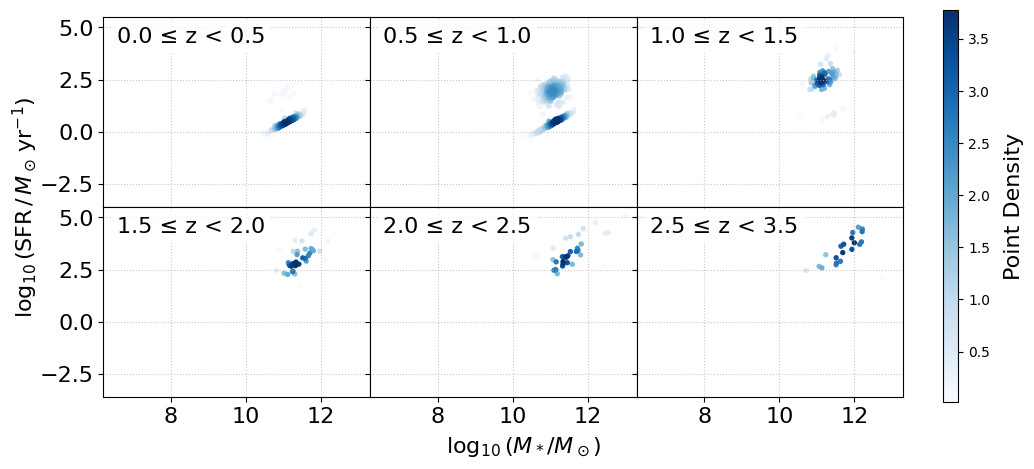

In [29]:
# Calculate global axis limits
x_min = min(emu_sources_best['log_stellar_mass'].min(), nonemu_samp_prots_best['log_stellar_mass'].min())
x_max = max(emu_sources_best['log_stellar_mass'].max(), nonemu_samp_prots_best['log_stellar_mass'].max())
y_min = min(emu_sources_best['log_sfr'].min(), nonemu_samp_prots_best['log_sfr'].min())
y_max = max(emu_sources_best['log_sfr'].max(), nonemu_samp_prots_best['log_sfr'].max())

# Add padding
x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (y_max - y_min)
xlim = (x_min - x_pad, x_max + x_pad)
ylim = (y_min - y_pad, y_max + y_pad)

# Create figure with adjusted spacing
fig, axes = plt.subplots(2, 3, figsize=(10, 5),  # Slightly larger figure
                        sharex=True, sharey=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0})

# Initialize variables for colorbar scaling
all_z_values = []

for i, (zmin, zmax) in enumerate(bins):
    ax = axes.flat[i]
    zmask1 = (emu_sources_best['bayes.universe.redshift'] >= zmin) & (emu_sources_best['bayes.universe.redshift'] < zmax)
    subset1 = emu_sources_best[zmask1]

    # Calculate the point density for EMU sources
    x1 = subset1['log_stellar_mass'].values
    y1 = subset1['log_sfr'].values
    xy1 = np.vstack([x1, y1])
    z1 = gaussian_kde(xy1)(xy1)
    
    all_z_values.extend(z1)
    
    idx1 = z1.argsort()
    x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]
    
    sc = ax.scatter(x1, y1, c=z1, s=8, cmap='Blues')
    
    # Add title inside plot
    ax.text(0.05, 0.95, f'{zmin} ≤ z < {zmax}', 
            transform=ax.transAxes,
            ha='left', va='top', fontsize=16,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set(xlim=xlim, ylim=ylim)

    ax.tick_params(axis='both', which='major', labelsize=16)  # Adjust major tick size
    ax.tick_params(axis='both', which='minor', labelsize=16)  # Adjust minor tick size

# Configure axis labels with adjusted positions
fig.text(0.5, 0.02, r'$\log_{10}(M_*/M_\odot)$', 
         ha='center', va='center', fontsize=16)
fig.text(0.001, 0.5, r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$', 
         ha='center', va='center', rotation='vertical', fontsize=16)

# Remove redundant tick labels
for ax in axes.flat:
    ax.label_outer()

# Create colorbar with better positioning and size
# Get position of the last subplot
last_ax = axes[-1, -1]
pos = last_ax.get_position()

# Create colorbar axes closer to the plots
cax = fig.add_axes([pos.x1 + 0.02,  # Closer to the plot
                   pos.y0, 
                   0.015,           # Wider than before
                   pos.height+0.4])

sm = ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(all_z_values), 
                                                    vmax=np.percentile(all_z_values, 95)))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Point Density', fontsize=16, labelpad=10)  # Added labelpad

# Adjust layout to accommodate the colorbar
plt.subplots_adjust(left=0.08,   # More space for y-label
                   right=0.88,  # Space for colorbar
                   bottom=0.12) # Space for x-label

plt.savefig("/home/polaris/Lab_Astro/relationship_all_density.png", 
           dpi=100, bbox_inches='tight', facecolor='white')
plt.show()

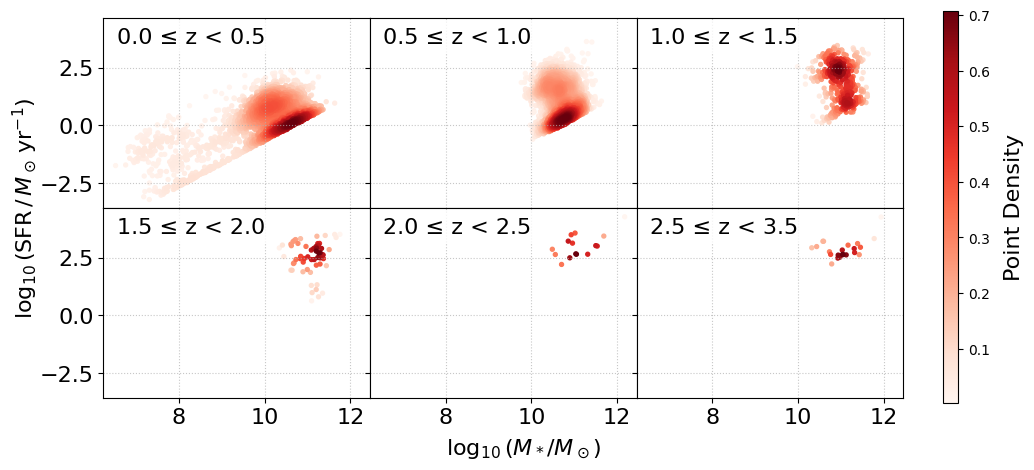

In [30]:
# Calculate global axis limits
x_min = min(nonemu_samp_prots_best['log_stellar_mass'].min(), nonemu_samp_prots_best['log_stellar_mass'].min())
x_max = max(nonemu_samp_prots_best['log_stellar_mass'].max(), nonemu_samp_prots_best['log_stellar_mass'].max())
y_min = min(nonemu_samp_prots_best['log_sfr'].min(), nonemu_samp_prots_best['log_sfr'].min())
y_max = max(nonemu_samp_prots_best['log_sfr'].max(), nonemu_samp_prots_best['log_sfr'].max())

# Add padding
x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (y_max - y_min)
xlim = (x_min - x_pad, x_max + x_pad)
ylim = (y_min - y_pad, y_max + y_pad)

# Create figure with adjusted spacing
fig, axes = plt.subplots(2, 3, figsize=(10, 5),  # Slightly larger figure
                        sharex=True, sharey=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0})

# Initialize variables for colorbar scaling
all_z_values = []

for i, (zmin, zmax) in enumerate(bins):
    ax = axes.flat[i]
    zmask1 = (nonemu_samp_prots_best['bayes.universe.redshift'] >= zmin) & (nonemu_samp_prots_best['bayes.universe.redshift'] < zmax)
    subset1 = nonemu_samp_prots_best[zmask1]

    # Calculate the point density for EMU sources
    x1 = subset1['log_stellar_mass'].values
    y1 = subset1['log_sfr'].values
    xy1 = np.vstack([x1, y1])
    z1 = gaussian_kde(xy1)(xy1)
    
    all_z_values.extend(z1)
    
    idx1 = z1.argsort()
    x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]
    
    sc = ax.scatter(x1, y1, c=z1, s=8, cmap='Reds')
    
    # Add title inside plot
    ax.text(0.05, 0.95, f'{zmin} ≤ z < {zmax}', 
            transform=ax.transAxes,
            ha='left', va='top', fontsize=16,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set(xlim=xlim, ylim=ylim)

    ax.tick_params(axis='both', which='major', labelsize=16)  # Adjust major tick size
    ax.tick_params(axis='both', which='minor', labelsize=16)  # Adjust minor tick size

# Configure axis labels with adjusted positions
fig.text(0.5, 0.02, r'$\log_{10}(M_*/M_\odot)$', 
         ha='center', va='center', fontsize=16)
fig.text(0.001, 0.5, r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$', 
         ha='center', va='center', rotation='vertical', fontsize=16)

# Remove redundant tick labels
for ax in axes.flat:
    ax.label_outer()

# Create colorbar with better positioning and size
# Get position of the last subplot
last_ax = axes[-1, -1]
pos = last_ax.get_position()

# Create colorbar axes closer to the plots
cax = fig.add_axes([pos.x1 + 0.02,  # Closer to the plot
                   pos.y0, 
                   0.015,           # Wider than before
                   pos.height+0.4])

sm = ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=np.min(all_z_values), 
                                                    vmax=np.percentile(all_z_values, 95)))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Point Density', fontsize=16, labelpad=10)  # Added labelpad

# Adjust layout to accommodate the colorbar
plt.subplots_adjust(left=0.08,   # More space for y-label
                   right=0.88,  # Space for colorbar
                   bottom=0.12) # Space for x-label

plt.savefig("/home/polaris/Lab_Astro/relationship_all_density.png", 
           dpi=100, bbox_inches='tight', facecolor='white')
plt.show()